# **Analyse**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

**Data loading**

Data frame pour visualisation

In [3]:
df = pd.read_csv('./data/final_data.zip')

/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_92862/459618280.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/final_data.zip')


In [4]:
df.sample(5)

,ID_ANSSI,Titre,Type,Date,CVE,CVSS,Base Severity,CWE,EPSS,Lien,Description,Éditeur,Produit,Versions affectées,Remote exploitable,Longueur description
179048,CERTFR-2025-AVI-0336,Multiples vulnérabilités dans le noyau Linux d...,Avis,2025-04-18T00:00:00.000000,CVE-2022-49468,NaN,NaN,Non disponible,0.00071,https://www.cert.ssi.gouv.fr/openapi.json,"In the Linux kernel, the following vulnerabili...",Linux,Linux,"8ea229511e06f9635ecc338dcbe0db41a73623f0, 8ea2...",False,1282.0
44586,CERTFR-2024-AVI-0634,Multiples vulnérabilités dans les produits Apple,Avis,2024-07-30T00:00:00.000000,CVE-2024-40812,7.8,Élevée,CWE-284,0.00060,https://www.cert.ssi.gouv.fr/openapi.json,A logic issue was addressed with improved chec...,Apple,iOS and iPadOS,unspecified,False,287.0
112908,CERTFR-2024-AVI-0557,Multiples vulnérabilités dans Microsoft Windows,Avis,2024-07-10T07:40:03.419387,CVE-2024-38069,7.0,Élevée,CWE-347,0.00048,https://www.cert.ssi.gouv.fr/openapi.json,Windows Enroll Engine Security Feature Bypass ...,Microsoft,Windows 10 Version 22H2,10.0.19045.0,False,59.0
46810,CERTFR-2024-AVI-1048,Multiples vulnérabilités dans le noyau Linux d...,Avis,2024-12-06T00:00:00.000000,CVE-2024-49867,NaN,NaN,Non disponible,0.00027,https://www.cert.ssi.gouv.fr/openapi.json,"In the Linux kernel, the following vulnerabili...",Linux,Linux,"4.19.323, 5.4.285, 5.10.227, 5.15.168, 6.1.113...",False,3998.0
81358,CERTFR-2024-AVI-0693,Multiples vulnérabilités dans le noyau Linux d...,Avis,2024-08-16T00:00:00.000000,CVE-2024-38594,NaN,NaN,Non disponible,0.00131,https://www.cert.ssi.gouv.fr/openapi.json,"In the Linux kernel, the following vulnerabili...",Linux,Linux,"5.14, 0, 6.6.55, 6.8.12, 6.9.3, 6.10",False,1644.0


In [5]:
df.shape

(225314, 16)

# Data cleaning

_Après avoir comparé nos visualisations selon différents cleaning de la data, nous avons décidé de simplement supprimer les lignes où il y a une colonne vide._

In [6]:
df_IA = df.dropna()
df_IA.shape

(109369, 16)

Conversion des types

In [7]:
df_IA['Date'] = pd.to_datetime(df_IA['Date'], format='%Y-%m-%dT%H:%M:%S.%f', errors='coerce')
df_IA["CVSS"] = pd.to_numeric(df_IA["CVSS"], errors="coerce")
df_IA["EPSS"] = pd.to_numeric(df_IA["EPSS"], errors="coerce")

/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_92862/2833215220.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IA['Date'] = pd.to_datetime(df_IA['Date'], format='%Y-%m-%dT%H:%M:%S.%f', errors='coerce')
/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_92862/2833215220.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IA["CVSS"] = pd.to_numeric(df_IA["CVSS"], errors="coerce")
/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_92862/2833215220.py:3: SettingWithCopyWar

In [8]:
df_IA.shape

(109369, 16)

In [9]:
df_IA = df_IA[df_IA["CWE"] != "Non disponible"]

Base severity

In [10]:
def gravite_from_cvss(cvss):
    if pd.isna(cvss):
        return "Non spécifié"
    if cvss >= 9.0:
        return "Critique"
    elif cvss >= 7.0:
        return "Élevée"
    elif cvss >= 4.0:
        return "Moyenne"
    else:
        return "Faible"

df_IA["Base Severity"] = df_IA["CVSS"].apply(gravite_from_cvss)

In [11]:
df_IA.shape

(98798, 16)

In [12]:
df_IA.sample(8)

,ID_ANSSI,Titre,Type,Date,CVE,CVSS,Base Severity,CWE,EPSS,Lien,Description,Éditeur,Produit,Versions affectées,Remote exploitable,Longueur description
42781,CERTFR-2023-AVI-0819,Multiples vulnérabilités dans les produits Sie...,Avis,2023-10-11 00:00:00.000000,CVE-2023-22786,9.8,Critique,CWE-120,0.00876,https://www.cert.ssi.gouv.fr/openapi.json,There are buffer overflow vulnerabilities in m...,Hewlett Packard Enterprise (HPE),Aruba Access Points running InstantOS and Arub...,"InstantOS 8.10.x.x: 8.10.0.2 and below, Arub...",True,402.0
214960,CERTFR-2024-AVI-0974,Multiples vulnérabilités dans Microsoft Office,Avis,2024-11-13 09:46:02.925164,CVE-2024-49032,7.8,Élevée,CWE-416,0.00051,https://www.cert.ssi.gouv.fr/openapi.json,Microsoft Office Graphics Remote Code Executio...,Microsoft,Microsoft Office LTSC for Mac 2021,16.0.1,False,61.0
132720,CERTFR-2024-AVI-0681,Multiples vulnérabilités dans Microsoft Windows,Avis,2024-08-14 13:42:38.425864,CVE-2024-38140,9.8,Critique,CWE-416,0.00053,https://www.cert.ssi.gouv.fr/openapi.json,Windows Reliable Multicast Transport Driver (R...,Microsoft,Windows 10 Version 1809,10.0.17763.0,False,88.0
161335,CERTFR-2024-AVI-0400,Multiples vulnérabilités dans Microsoft Windows,Avis,2024-05-15 02:00:00.000000,CVE-2024-30019,6.5,Moyenne,CWE-400,0.00052,https://www.cert.ssi.gouv.fr/openapi.json,DHCP Server Service Denial of Service Vulnerab...,Microsoft,Windows Server 2008 R2 Service Pack 1 (Server ...,6.1.7601.0,False,51.0
40583,CERTFR-2024-AVI-0926,Multiples vulnérabilités dans le noyau Linux d...,Avis,2024-10-25 00:00:00.000000,CVE-2023-6546,7.0,Élevée,CWE-416,0.00267,https://www.cert.ssi.gouv.fr/openapi.json,A race condition was found in the GSM 0710 tty...,Red Hat,Red Hat Enterprise Linux 9.0 Extended Update S...,0:5.14.0-70.93.1.rt21.165.el9_0,False,396.0
160780,CERTFR-2024-AVI-0292,Multiples vulnérabilités dans les produits Mic...,Avis,2024-04-10 02:00:00.000000,CVE-2024-28936,8.8,Élevée,CWE-190,0.00043,https://www.cert.ssi.gouv.fr/openapi.json,Microsoft ODBC Driver for SQL Server Remote Co...,Microsoft,Microsoft ODBC Driver 17 for SQL Server on Linux,17.0.0.0,False,72.0
1992,CERTFR-2023-AVI-0130,Multiples vulnérabilités dans Microsoft Windows,Avis,2023-02-15 00:00:00.000000,CVE-2023-21688,7.8,Élevée,CWE-416,0.02645,https://www.cert.ssi.gouv.fr/openapi.json,NT OS Kernel Elevation of Privilege Vulnerability,Microsoft,Windows 10 Version 1507,10.0.10240.0,False,49.0
41515,CERTFR-2025-AVI-0401,Multiples vulnérabilités dans Juniper Networks...,Avis,2025-05-14 00:00:00.000000,CVE-2024-11218,8.6,Élevée,CWE-269,0.00032,https://www.cert.ssi.gouv.fr/openapi.json,A vulnerability was found in `podman build` an...,Red Hat,Red Hat OpenShift Container Platform 4.15,415.92.202503060749-0,False,303.0


In [13]:
df_vis = df_IA.copy()

# **Visualisation**

**Severity level categorization function**

In [14]:
def cvss_to_severity(score):
    try:
        score = float(score)
        if score <= 3:
            return 'Faible'
        elif score <= 6:
            return 'Moyenne'
        elif score <= 8:
            return 'Élevée'
        else:
            return 'Critique'
    except:
        return 'Inconnu'

## 1. Histogram of severity levels (based on CVSS)

_Dans l'histogramme avant nettoyage, on observe une forte dominance de la classe "Critique", qui dépasse nettement les 120 000 occurrences. La classe "Élevée" suit, avec environ 70 000 cas, tandis que les classes "Moyenne" et surtout "Faible" sont très sous-représentées (moins de 5 000 cas pour "Faible")._

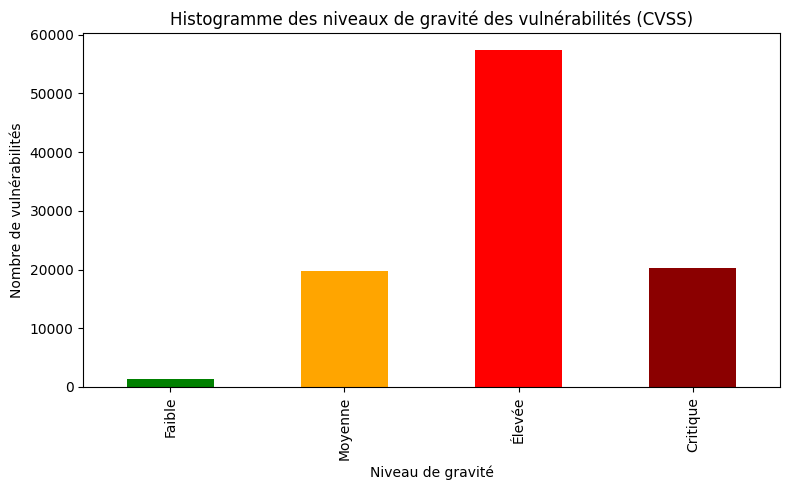

In [15]:
df_vis['Gravité'] = df_vis['CVSS'].apply(cvss_to_severity)
grav_counts = df_vis['Gravité'].value_counts().reindex(['Faible', 'Moyenne', 'Élevée', 'Critique'], fill_value=0)

# Plot
plt.figure(figsize=(8,5))
grav_counts.plot(kind='bar', color=['green', 'orange', 'red', 'darkred', 'gray'])
plt.title('Histogramme des niveaux de gravité des vulnérabilités (CVSS)')
plt.xlabel('Niveau de gravité')
plt.ylabel('Nombre de vulnérabilités')
plt.tight_layout()
plt.show()

_Dans le graphique après nettoyage, la classe "Critique" chute à environ 25 000 vulnérabilités, tandis que la classe "Élevée" devient majoritaire avec environ 55 000 cas. La classe "Moyenne" reste relativement stable, et "Faible" toujours marginale._

_Ce changement significatif s’explique par la suppression de lignes avec des colonnes vides. En effet, après plusieurs visualisations, nous avons compris que ce n'est pas la suppression des lignes avec un CVSS manquant mais plutôt celles avec des cases vides dans d'autres colonnes._

## 2. Circular vulnerability diagram (CWE)

Top 10 CWE les plus fréquents, les autres groupés par "Others"

In [16]:
top_cwe = df_vis['CWE'].value_counts()
top_18 = top_cwe.head(18)
autres = top_cwe[18:].sum()
top_18['Autres'] = autres

Plot

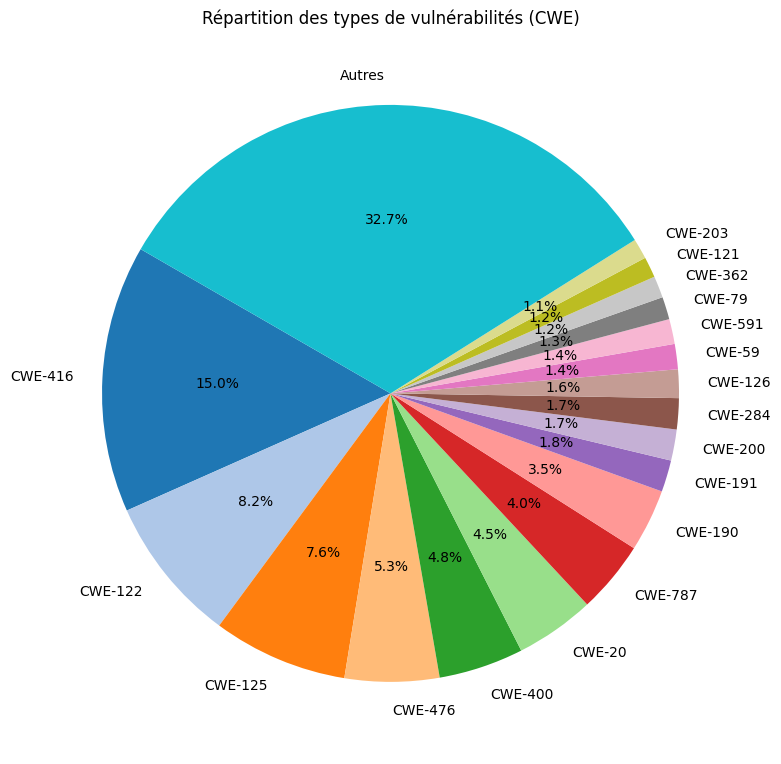

In [17]:
plt.figure(figsize=(8,8))
colors = plt.cm.tab20.colors[:len(top_18)]
top_18.plot(kind='pie', autopct='%1.1f%%', startangle=150, colors=colors)
plt.title('Répartition des types de vulnérabilités (CWE)')
plt.ylabel('')
plt.tight_layout()
plt.show()

_Le diagramme montre que les vulnérabilités sont très diverses, avec un tiers (32,7 %) regroupées sous la catégorie "Autres", ce qui indique une large variété de failles peu fréquentes individuellement. Parmi les types spécifiques, la faille la plus fréquente est CWE-416 (Use After Free, 15,0 %), une erreur critique liée à l’utilisation de la mémoire après libération, souvent exploitée pour exécuter du code malveillant. Elle est suivie par CWE-122 (Heap-based Buffer Overflow, 8,2 %) et CWE-125 (Out-of-bounds Read, 7,6 %), une lecture hors des limites de la mémoire, qui peut entraîner la fuite d’informations sensibles._

_Les dépassements de tampon sont aussi très représentés avec CWE-787 (Out-of-bounds Write, 4,0 %), pouvant permettre une prise de contrôle du système. CWE-476 (NULL Pointer Dereference, 5,3 %) cause souvent des plantages d’application, tandis que CWE-400 (Uncontrolled Resource Consumption, 4,8 %) désigne des attaques par saturation des ressources comme le DoS. CWE-20 (Improper Input Validation, 4,5 %) montre que de nombreux systèmes ne filtrent pas correctement les données d’entrée, ce qui les rend vulnérables à diverses injections._

_Parmi les failles moins fréquentes mais notables, on trouve CWE-200 (Information Exposure, 1,7 %), CWE-190 (Integer Overflow, 3,5 %), CWE-79 (Cross-site Scripting), CWE-284 (Improper Access Control), et CWE-362 (Race Condition), toutes potentiellement critiques selon leur contexte d’exploitation. Globalement, on remarque que beaucoup de ces vulnérabilités viennent de mauvaises pratiques de programmation, notamment dans la gestion de la mémoire ou dans le manque de vérification des données, surtout dans des langages comme C ou C++._

## 3. EPSS Score Density Curve

In [18]:
epss = df_vis['EPSS']

Plot

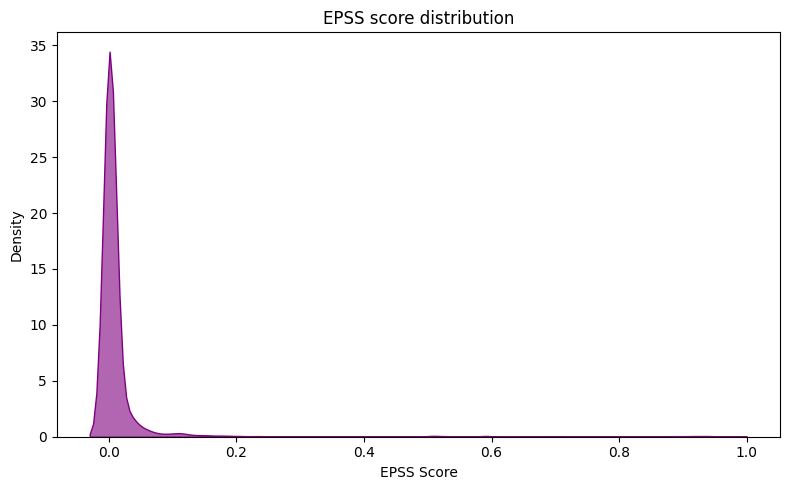

In [19]:
plt.figure(figsize=(8, 5))
sns.kdeplot(epss, fill=True, color="purple", alpha=0.6)
plt.title('EPSS score distribution')
plt.xlabel('EPSS Score')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

_Cette visualisation montre la distribution des scores EPSS (Exploit Prediction Scoring System) pour les vulnérabilités présentes dans le jeu de données. Le score EPSS est une mesure qui estime la probabilité qu'une vulnérabilité soit exploitée dans les 30 prochains jours. Il varie entre 0 et 1 : plus le score est élevé, plus le risque d’exploitation est grand._

_La courbe indique que la grande majorité des vulnérabilités ont un score très proche de 0, ce qui signifie qu’elles présentent un risque faible d’exploitation. Très peu de vulnérabilités ont des scores élevés, ce qui est visible à travers la faible densité au-delà de 0.2._

_Cela montre que, même si beaucoup de vulnérabilités sont présentes, peu sont réellement critiques d’un point de vue exploitation. Il reste néanmoins important de surveiller celles qui ont un score plus élevé, car ce sont elles qui nécessitent une attention prioritaire en matière de cybersécurité._

Zoom sur les petits EPSS Score

In [20]:
epss_filtered = epss[(epss >= 0) & (epss <= 0.10)]

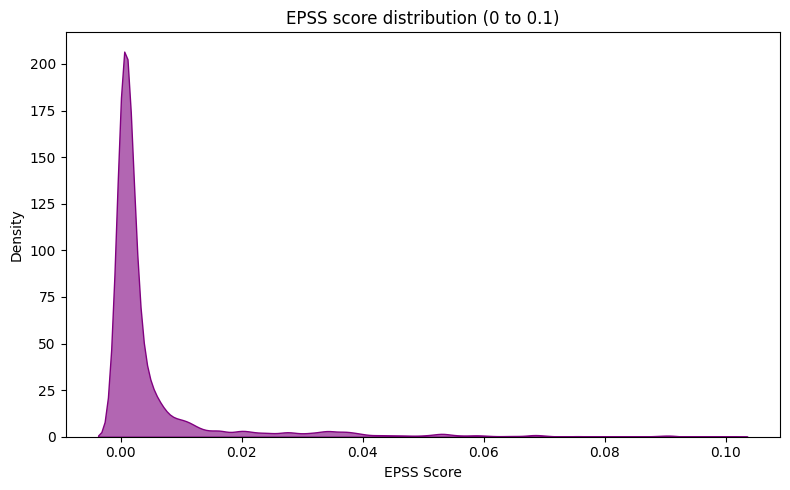

In [21]:
plt.figure(figsize=(8, 5))
sns.kdeplot(epss_filtered, fill=True, color="purple", alpha=0.6)
plt.title('EPSS score distribution (0 to 0.1)')
plt.xlabel('EPSS Score')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

## 4. Top Affected editors

Top 10 editeurs les plus fréquents

In [22]:
top_editors = df_vis['Éditeur'].value_counts().head(10)

Plot

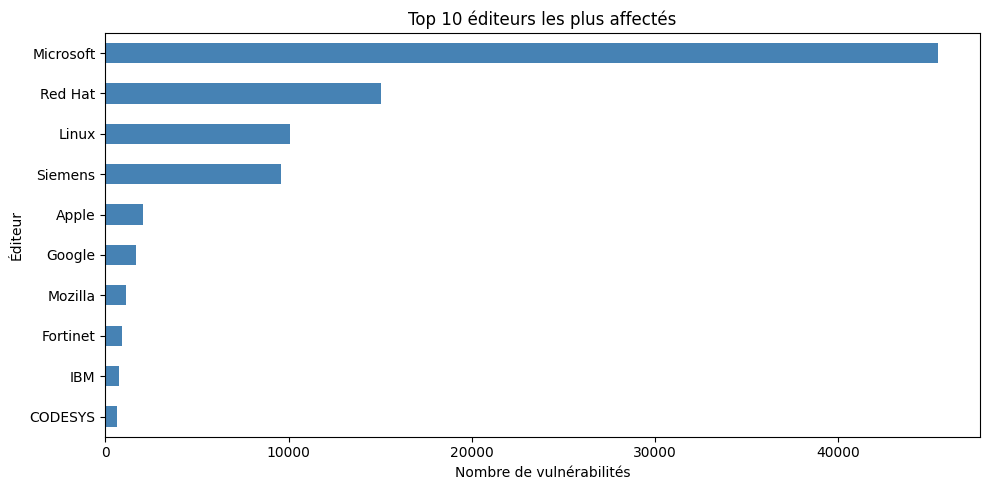

In [23]:
plt.figure(figsize=(10, 5))
top_editors.plot(kind='barh', color='steelblue')
plt.title('Top 10 éditeurs les plus affectés')
plt.xlabel('Nombre de vulnérabilités')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

_Cette visualisation montre les 10 éditeurs les plus touchés par des vulnérabilités. Microsoft domine largement avec plus de 45 000 vulnérabilités, suivi par Red Hat (environ 16 000) et Linux (environ 11 000). Les autres éditeurs comme Siemens, Apple, Google ou Mozilla présentent des volumes bien moindres. Cela reflète des différences en termes de surface d’attaque, de types de produits ou de politiques de gestion des vulnérabilités._

_Pour l’analyse en machine learning, ces données peuvent orienter le choix des variables. Dans un modèle non supervisé comme K-Means, le nombre de vulnérabilités par éditeur, leur criticité ou leur nature peuvent permettre d’identifier des groupes cohérents (ex. : industriels vs systèmes d’exploitation). Dans un modèle supervisé comme Random Forest, ces mêmes variables peuvent servir à prédire le niveau de gravité ou de risque d’une alerte. Il faut cependant veiller à l’équilibre des classes, car certains éditeurs dominants peuvent biaiser l’apprentissage._

## 5. Top affected products

Top 10 produits les plus fréquents

In [24]:
top_products = df_vis['Produit'].value_counts().head(10)

Plot

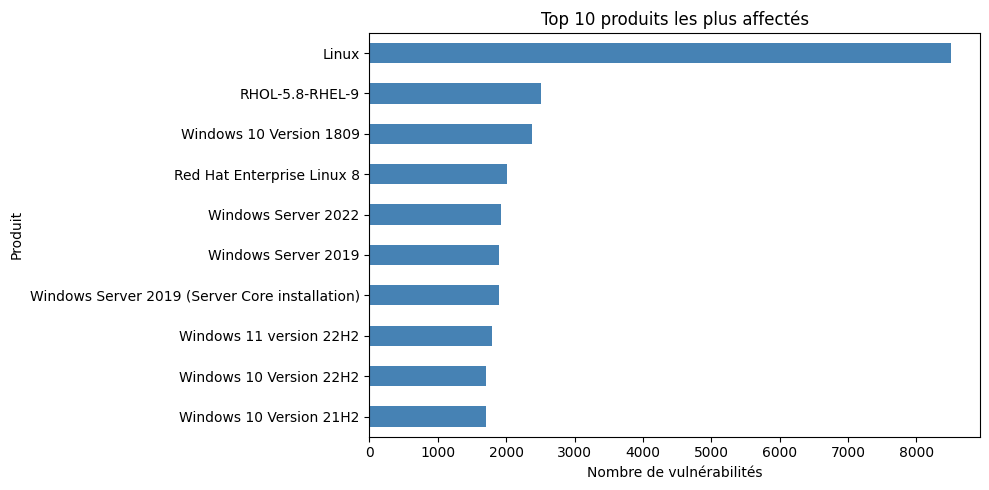

In [25]:
plt.figure(figsize=(10, 5))
top_products.plot(kind='barh', color='steelblue')
plt.title('Top 10 produits les plus affectés')
plt.xlabel('Nombre de vulnérabilités')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

_Ce graphique présente les 10 produits les plus touchés par des vulnérabilités selon les données issues des alertes ANSSI enrichies par les CVE. Le système Linux arrive largement en tête avec plus de 8 000 vulnérabilités, ce qui montre son exposition importante, probablement liée à sa large utilisation et à sa nature open source. On retrouve ensuite plusieurs versions de systèmes d’exploitation Windows (comme Windows 10, 11 et Server) et de distributions Linux d’entreprise telles que Red Hat ou RHEL, ce qui reflète la concentration des vulnérabilités dans les systèmes d’exploitation largement déployés dans les environnements professionnels._

## 6. Heatmap : Correlation between CVSS and EPSS

Créer un dataframe correlation

In [26]:
correlation_df = df_vis[["CVSS", "EPSS"]]

In [27]:
df_vis["Gravité_CVSS"] = df_vis["CVSS"].apply(cvss_to_severity)

Categoriser EPSS en 4 niveaux

In [28]:
def epss_to_level(epss):
    if epss <= 0.25:
        return "Faible"
    elif epss <= 0.5:
        return "Moyenne"
    elif epss <= 0.75:
        return "Élevée"
    else:
        return "Critique"

In [29]:
df_vis["Probabilité_EPSS"] = df_vis["EPSS"].apply(epss_to_level)

Création de la heatmap

In [30]:
heatmap_data = pd.crosstab(df_vis["Gravité_CVSS"], df_vis["Probabilité_EPSS"])
heatmap_data = heatmap_data.reindex(index=["Critique", "Élevée", "Moyenne", "Faible"],
                                     columns=["Faible", "Moyenne", "Élevée", "Critique"])

Plot

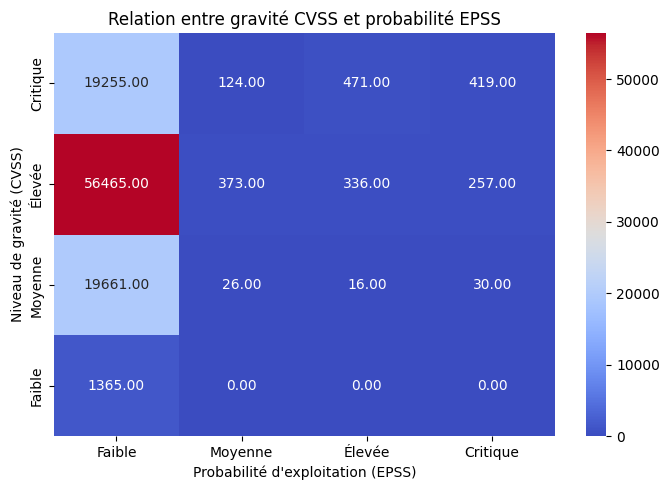

In [31]:
plt.figure(figsize=(7, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Relation entre gravité CVSS et probabilité EPSS")
plt.xlabel("Probabilité d'exploitation (EPSS)")
plt.ylabel("Niveau de gravité (CVSS)")
plt.tight_layout()
plt.show()

_Cette heatmap illustre la relation observée entre le niveau de gravité CVSS (axe vertical) et la probabilité d’exploitation EPSS (axe horizontal). Chaque case indique le nombre de vulnérabilités correspondant à une combinaison de gravité et de probabilité d’exploitation._

_On constate que la plupart des vulnérabilités sont classées comme ayant une gravité élevée, mais avec une faible probabilité d’exploitation. Par exemple, plus de 56 000 vulnérabilités sont considérées comme « Élevées » tout en ayant une probabilité d’exploitation faible, et près de 20 000 vulnérabilités sont « Moyennes » avec également une faible probabilité._

_Les cas combinant gravité critique et probabilité d’exploitation élevée ou critique sont relativement rares. Cela montre que, dans mes données, les failles les plus critiques sont peu nombreuses et que la majorité des vulnérabilités graves ne sont pas nécessairement exploitables facilement._

## 7. Scatter plot : CVSS vs EPSS

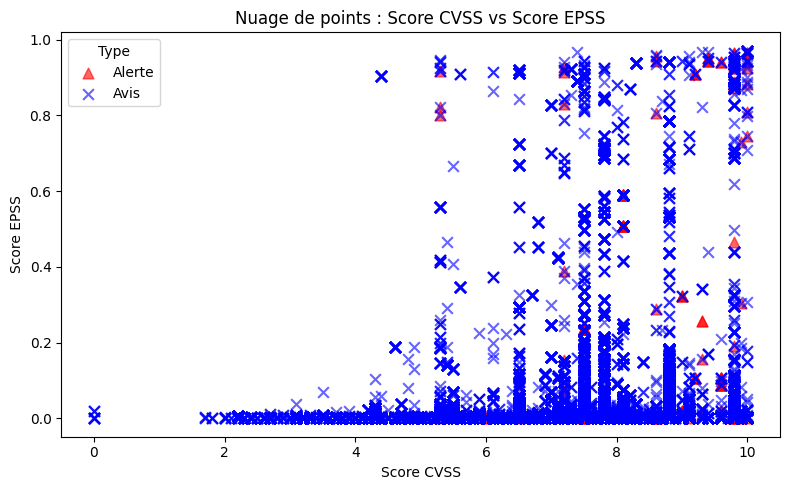

In [32]:
plt.figure(figsize=(8, 5))

# Couleurs et marqueurs pour chaque type
color_map = {'Alerte': 'red', 'Avis': 'blue'}
marker_map = {'Alerte': '^', 'Avis': 'x'}

for t in ['Alerte', 'Avis']:
    subset = df_vis[df_vis['Type'] == t]
    plt.scatter(subset['CVSS'], subset['EPSS'],
                color=color_map[t],
                marker=marker_map[t],
                alpha=0.6,
                s=60,
                label=t)

plt.title("Nuage de points : Score CVSS vs Score EPSS")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.legend(title="Type")
plt.tight_layout()
plt.show()


_Ce nuage de points représente la relation entre le score de gravité CVSS (axe horizontal) et le score de probabilité d’exploitation EPSS (axe vertical), pour les vulnérabilités présentes dans mon dataset. Chaque point correspond à une vulnérabilité, et sa couleur indique son type :_

_- les triangles rouges représentent les alertes,_

_- les croix bleues représentent les avis._

_On observe une nette disproportion en faveur des avis, qui sont beaucoup plus nombreux dans le dataset. Cela est cohérent avec leur nature._

_On remarque que la majorité des vulnérabilités se situent dans la zone inférieure droite du graphique, c’est-à-dire avec un score CVSS élevé mais un score EPSS faible. Cela confirme une tendance déjà observée : une gravité importante n’implique pas forcément une forte probabilité d’exploitation._

_Les vulnérabilités combinant un score CVSS élevé et un score EPSS élevé, bien qu’elles soient plus rares, existent dans mon jeu de données, et se retrouvent dans le coin supérieur droit du graphique. Ce sont les cas les plus critiques et donc les plus préoccupants en matière de sécurité._

_Enfin, les alertes (triangles rouges) ont tendance à apparaître plus fréquemment dans les zones de scores plus élevés, que ce soit en CVSS ou en EPSS, ce qui reflète une classification plus urgente._

## 8. Courbe cumulative : Vulnérabilités dans le temps

In [33]:
df_sorted = df_vis.sort_values("Date")

Regroupement par date et calcul de la somme cumulée

In [34]:
cumulative_df = df_sorted.groupby("Date").size().cumsum()

Plot

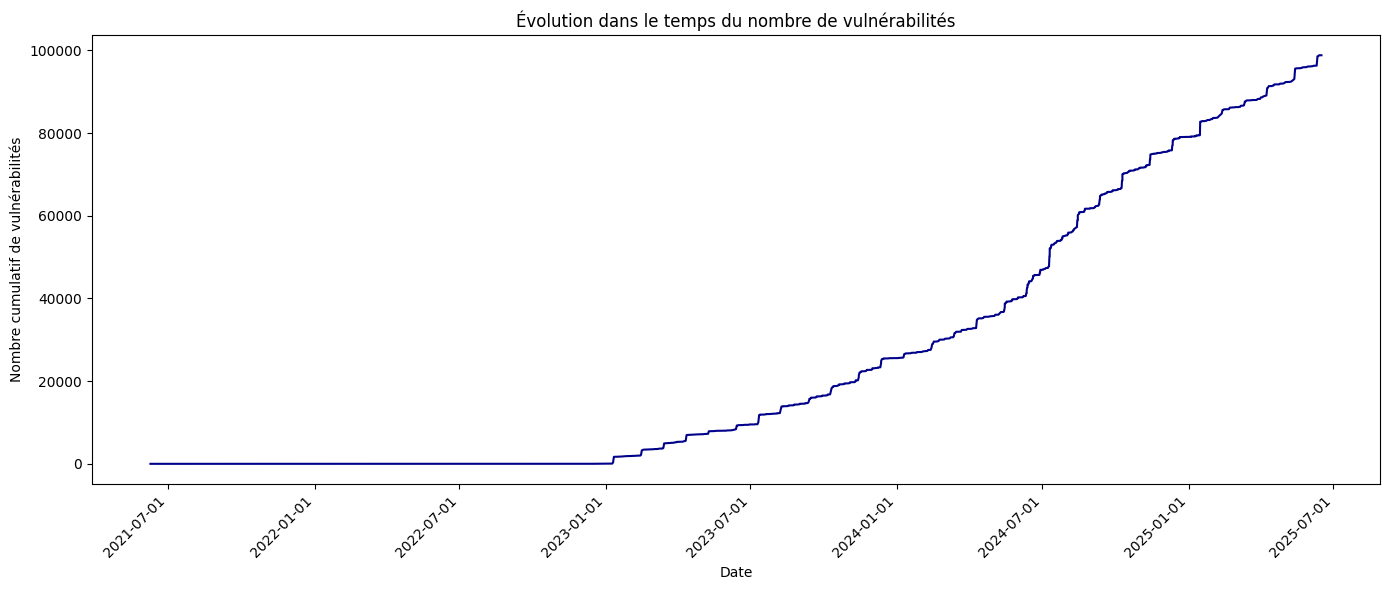

In [35]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(cumulative_df.index, cumulative_df.values, color="darkblue")

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

plt.title("Évolution dans le temps du nombre de vulnérabilités")
plt.xlabel("Date")
plt.ylabel("Nombre cumulatif de vulnérabilités")
plt.tight_layout()
plt.show()

_Ce graphique montre l’évolution cumulative du nombre de vulnérabilités détectées dans le temps. On observe une forte augmentation à partir du début de l’année 2023, avec une croissance rapide et continue jusqu’à mi-2025. Cette tendance s'explique en partie par la structure de notre jeu de données, puisque la majorité des CVE ont été collectées à partir de 2023 (alertes à partir de 2021 et avis à partir de 2023). Cela explique la quasi-absence de vulnérabilités avant cette date, qui résulte davantage d’un manque de données que d’une réelle stabilité._

_Cependant, malgré ce biais lié à la collecte, on constate tout de même une tendance de fond à la hausse, ce qui souligne l'augmentation continue des failles de sécurité au fil du temps. Cela met en évidence l'importance croissante des enjeux liés à la sécurité réseau et à la cybersécurité._

## 9. Boxplot : scores CVSS par top éditeurs

Filtre

In [36]:
top_editors = df_vis['Éditeur'].value_counts().head(10).index
boxplot_df = df_vis[df_vis['Éditeur'].isin(top_editors)]

Plot

/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_92862/3526360994.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=boxplot_df, x='Éditeur', y='CVSS', palette='Set2')


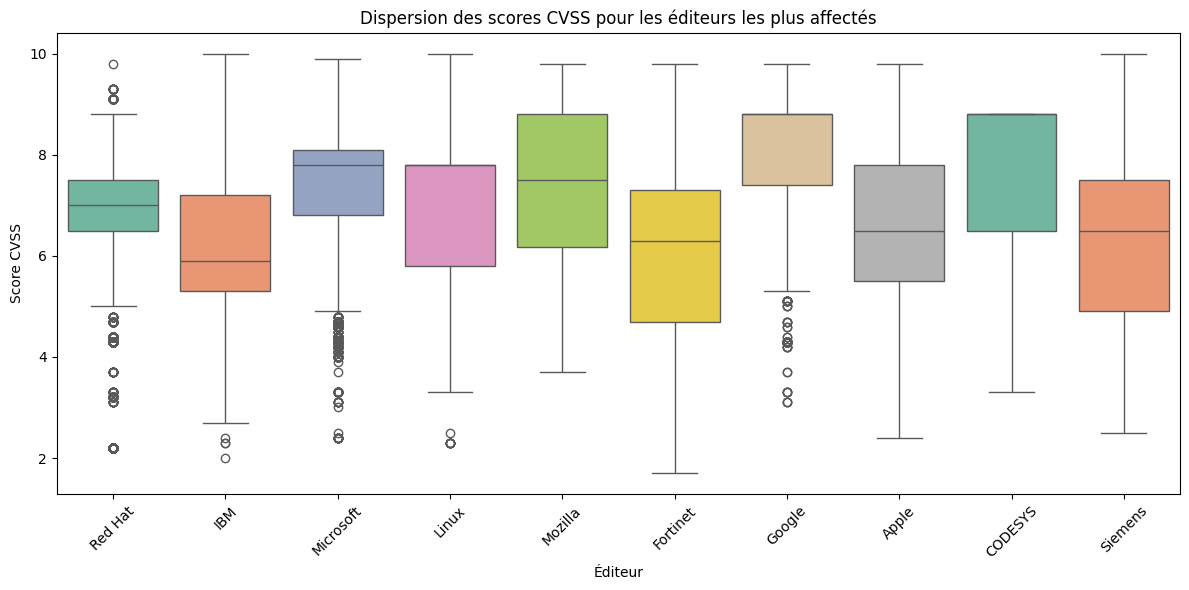

In [37]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=boxplot_df, x='Éditeur', y='CVSS', palette='Set2')
plt.title('Dispersion des scores CVSS pour les éditeurs les plus affectés')
plt.xlabel('Éditeur')
plt.ylabel('Score CVSS')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

_Cette visualisation représente la dispersion des scores CVSS (Common Vulnerability Scoring System) pour les vulnérabilités signalées chez différents éditeurs, parmi les plus affectés. Chaque boîte (boxplot) donne une idée de la distribution des scores pour un éditeur donné, en montrant la médiane (ligne horizontale dans la boîte), les quartiles (limites de la boîte), ainsi que les valeurs extrêmes (moustaches et points)._

_On observe que Microsoft, Google, Mozilla et CODESYS présentent une majorité de vulnérabilités avec des scores CVSS élevés (souvent supérieurs à 7), indiquant des failles critiques ou sévères. Microsoft se distingue par une forte concentration autour de 8, avec relativement peu de scores faibles, ce qui peut traduire un nombre élevé de vulnérabilités jugées graves._

_À l'inverse, IBM, Fortinet, Apple et Siemens montrent une plus grande dispersion des scores, avec une présence plus notable de vulnérabilités de sévérité moyenne voire faible. Par exemple, Fortinet a des scores allant de très bas (environ 1,7) à très élevés, ce qui témoigne d'une grande variété dans la gravité des vulnérabilités découvertes._

_Red Hat, Linux et Mozilla ont des distributions relativement étalées, mais avec une médiane qui reste haute, montrant une tendance générale à des vulnérabilités importantes. À noter également la présence de nombreux outliers (points individuels hors de la boîte), notamment pour Microsoft et Red Hat, qui indiquent des cas atypiques ou exceptionnels._

## 10. Évolution temporelle des vulnérabilités CWE-416 (« Use After Free » : utilisation après libération de la mémoire)

In [38]:
cwe_416_df = df_vis[df_vis["CWE"] == "CWE-416"]

Grouper par mois

In [39]:
cwe_416_monthly = cwe_416_df.groupby(df_vis["Date"].dt.to_period("M")).size()
cwe_416_monthly.index = cwe_416_monthly.index.to_timestamp()

Plot

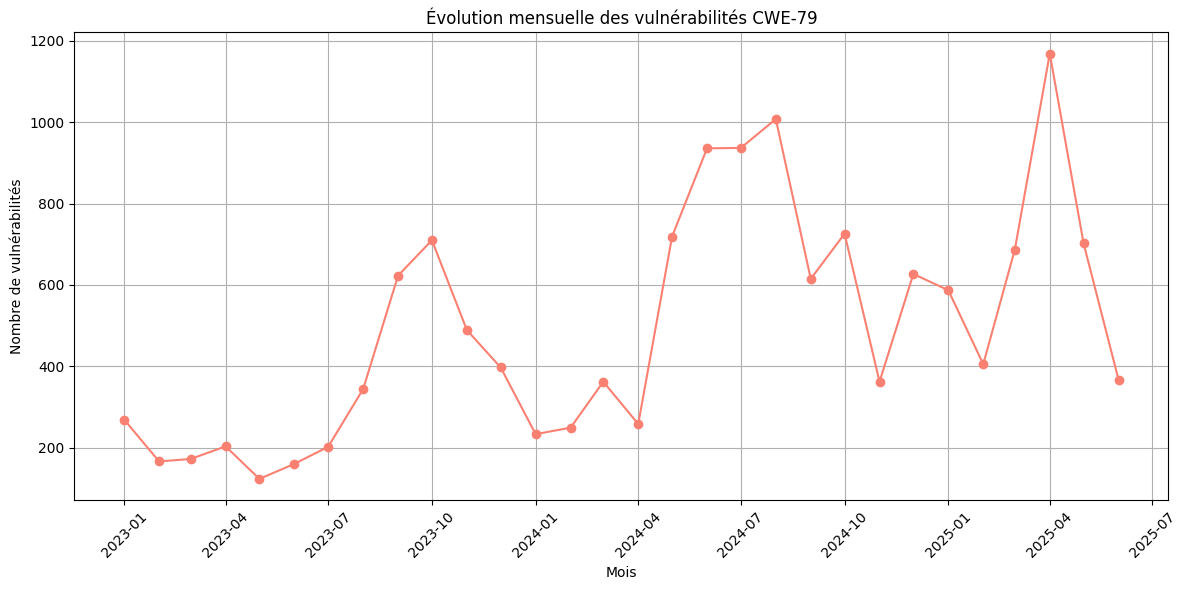

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(cwe_416_monthly.index, cwe_416_monthly.values, marker="o", linestyle="-", color="salmon")
plt.title("Évolution mensuelle des vulnérabilités CWE-416")
plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

_Le nombre de vulnérabilités associées à CWE-416 (Use-After-Free) reste relativement faible et stable entre janvier et juin 2023, oscillant entre 130 et 250 cas par mois. Une première hausse nette s’observe à partir de juillet 2023, culminant à environ 720 vulnérabilités en octobre 2023._

_Suite à une baisse progressive en fin d’année 2023, une nouvelle vague beaucoup plus marquée apparaît dès avril 2024, atteignant un plateau élevé pendant l’été avec un pic autour de 1 000 vulnérabilités en août 2024. Après quelques variations, une forte flambée est visible en avril 2025, où le nombre dépasse brièvement 1 150 signalements, avant de redescendre._

_Cette évolution peut refléter soit une amélioration des outils d’analyse mémoire statique et dynamique, soit une exploitation plus systématique de cette faille critique. CWE-416 est en effet redoutable car elle permet souvent une exécution de code arbitraire, ce qui en fait une cible privilégiée dans les audits de sécurité et les programmes de bug bounty. Sa recrudescence souligne l’importance constante de la gestion mémoire sécurisée dans le développement logiciel, notamment en C et C++._

## 11. Histogramme des vulnérabilités par produit pour CWE-125 : Lecture hors limites

Selection du CWE-125

In [41]:
cwe_cible = "CWE-125"
df_cwe = df_vis[df_vis["CWE"] == cwe_cible]

Compter les vulnérabilités par produit

In [42]:
produit_counts = df_cwe["Produit"].value_counts().sort_values(ascending=False).head(15)

Plot

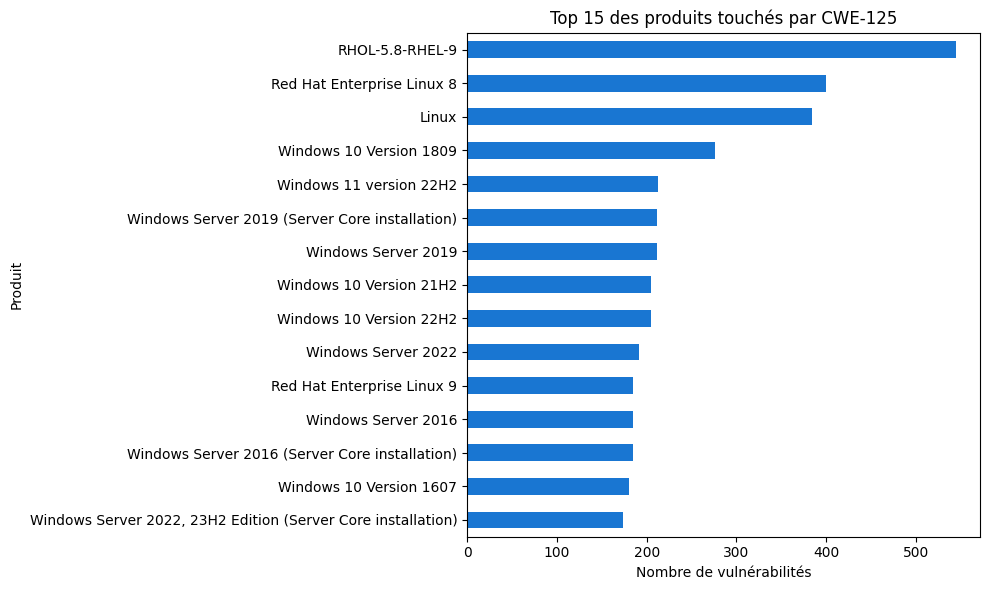

In [43]:
plt.figure(figsize=(10,6))
produit_counts.plot(kind="barh", color="#1976D2")
plt.gca().invert_yaxis()
plt.title(f"Top 15 des produits touchés par {cwe_cible}")
plt.xlabel("Nombre de vulnérabilités")
plt.ylabel("Produit")
plt.tight_layout()
plt.show()

_CWE-125 (lecture hors limites) touche principalement les systèmes basés sur Linux, avec en tête RHOL-5.8-RHEL-9, suivi de près par Linux et plusieurs versions de Red Hat Enterprise Linux (RHEL 6 à 9)._

_Les systèmes Windows sont également fortement représentés, en particulier Windows 10 Version 1809, Windows Server 2019, et Windows 11 version 22H2._

_Le classement montre que cette vulnérabilité est largement répandue dans les systèmes d’exploitation modernes, qu’ils soient open source ou propriétaires, ce qui souligne la fragilité persistante des accès mémoire non sécurisés dans de nombreux environnements._

## 12. Heatmap CWE x editeur

Heatmap

In [44]:
heatmap_data = pd.crosstab(df_vis["CWE"], df_vis["Éditeur"])

Selection (sinon trop de valeurs)

In [45]:
top_cwe = heatmap_data.sum(axis=1).sort_values(ascending=False).head(15).index
top_editeurs = heatmap_data.sum(axis=0).sort_values(ascending=False).head(14).index
filtered_data = heatmap_data.loc[top_cwe, top_editeurs]

Plot

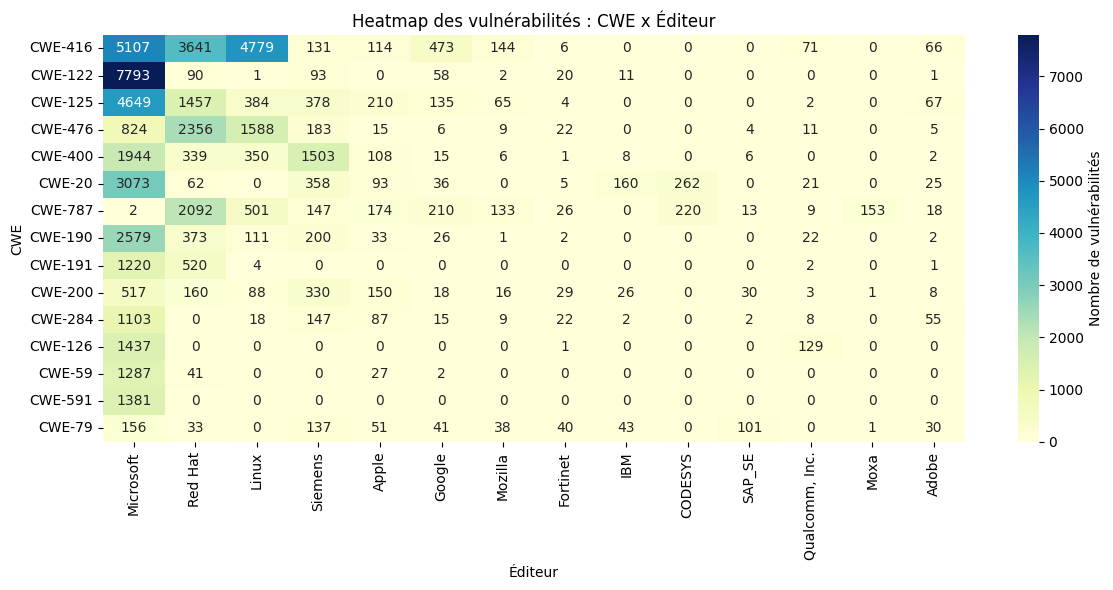

In [46]:
plt.figure(figsize=(12, 6))
sns.heatmap(filtered_data, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Nombre de vulnérabilités'})
plt.title("Heatmap des vulnérabilités : CWE x Éditeur")
plt.xlabel("Éditeur")
plt.ylabel("CWE")
plt.tight_layout()
plt.show()

_CWE-122 (débordement de tampon) et CWE-416 (use-after-free) sont les deux vulnérabilités les plus massivement signalées, notamment chez Microsoft et Red Hat._

_CWE-476 (référence de pointeur nul) est particulièrement fréquente chez Red Hat (3 213) et Linux (1 624), ce qui reflète leur forte exposition aux erreurs de gestion de mémoire dynamique._

_CWE-787 (écriture hors limites) est surtout concentrée chez Red Hat, Linux, et Apple, tandis que CWE-400 (déni de service) est significativement élevée chez Siemens, ce qui corrobore les problématiques spécifiques aux systèmes industriels._

_En comparaison, certains éditeurs comme OpenSSL, SAP_SE, ou IBM présentent un volume beaucoup plus limité et concentré sur quelques types de CWE._

## 13. Tendances mensuelles de la vulnérabilité par CWE (courbes superposées)

Extraction du mois et de l'année

In [47]:
df_vis["Mois"] = df_vis["Date"].dt.to_period("M")  # Format AAAA-MM

Garder les 8 CWE les plus fréquents

In [48]:
top_cwes = df_vis[df_vis["CWE"] != "Non disponible"]["CWE"].value_counts().head(5).index
df_top = df_vis[df_vis["CWE"].isin(top_cwes)]

Garder seulement après janvier 2023

In [49]:
df_top = df_top[df_top["Mois"] >= "2023-01"]

Groupement : nombre de vulnérabilités par mois et par CWE

In [50]:
df_grouped = df_top.groupby(["Mois", "CWE"]).size().unstack(fill_value=0)

Plot

<Figure size 1200x600 with 0 Axes>

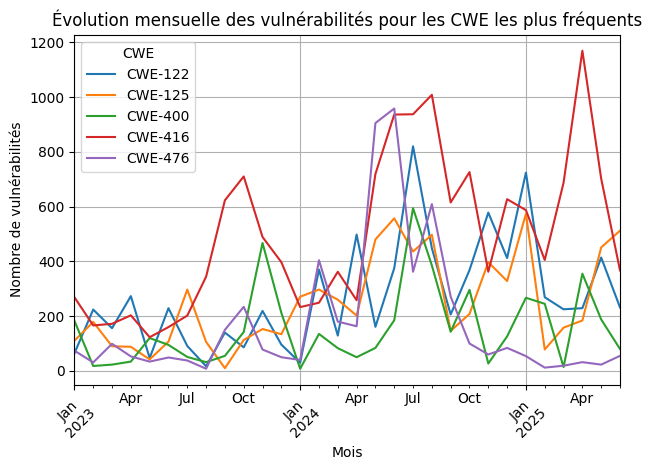

In [51]:
plt.figure(figsize=(12, 6))
df_grouped.plot()
plt.title("Évolution mensuelle des vulnérabilités pour les CWE les plus fréquents")
plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.legend(title="CWE")
plt.tight_layout()
plt.grid(True)
plt.show()

_Parmi les CWE suivis, CWE-416 (use-after-free) est clairement la plus fréquente, avec plusieurs pics au-dessus de 1 000 vulnérabilités, notamment à l’automne 2023 et au printemps 2025._

_CWE-476 (référence de pointeur nul) connaît un pic exceptionnel en juin 2024, où elle dépasse temporairement toutes les autres catégories._

_Les autres failles — CWE-122 (débordement de tampon), CWE-125 (lecture hors limites) et CWE-400 (déni de service) — montrent une évolution plus irrégulière, avec des pics partagés selon les mois mais un volume global moins élevé._

_Ce graphique illustre bien la variabilité mensuelle des vulnérabilités selon le type d’erreur, tout en confirmant la domination persistante des failles de gestion mémoire._

## 14. Heatmap : vunerabilités temporelles

In [52]:
df_vis["Année"] = df_vis["Date"].dt.year
df_vis["Mois"] = df_vis["Date"].dt.month

In [53]:
pivot = pd.crosstab(df_vis["Année"], df_vis["Mois"]).fillna(0)

Plot

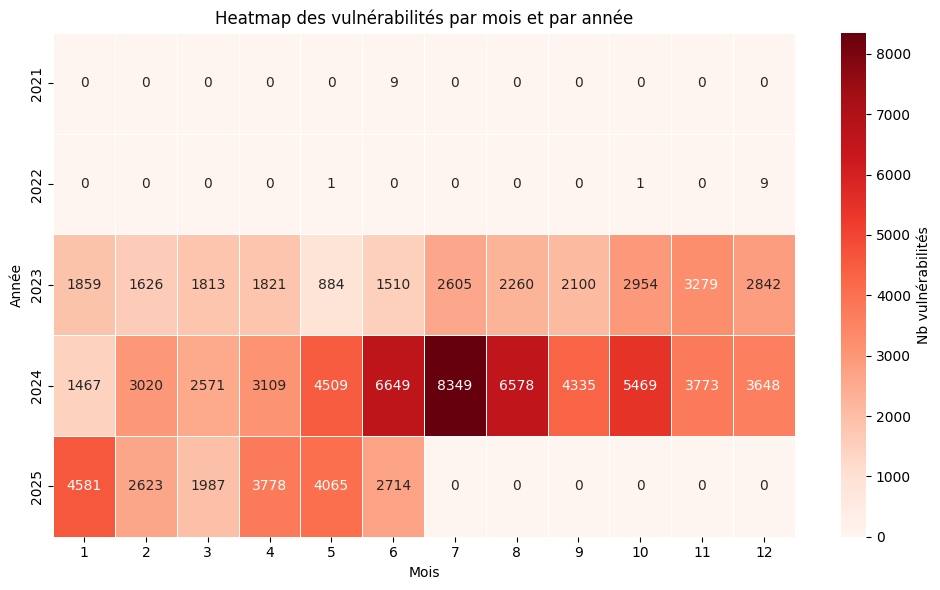

In [54]:
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap="Reds", annot=True, fmt=".0f", linewidths=.5, cbar_kws={'label': 'Nb vulnérabilités'})
plt.title("Heatmap des vulnérabilités par mois et par année")
plt.xlabel("Mois")
plt.ylabel("Année")
plt.tight_layout()
plt.show()

_L’activité de publication de vulnérabilités est quasiment inexistante avant 2023, avec quelques cas isolés en 2021 et 2022._

_L’année 2023 marque un tournant avec une montée progressive tout au long de l’année, culminant en octobre et novembre (plus de 4 000 vulnérabilités par mois)._

_L’année 2024 atteint un pic historique en juillet avec 9 244 vulnérabilités, et maintient un niveau d’activité élevé sur l’ensemble de l’année._

_Pour 2025, les six premiers mois déjà montrent des données avec un fort volume suggérant une augmentation au cours du temps._

_Cette évolution traduit un accroissement important de la détection ou de la déclaration de vulnérabilités._

## 15. Scatter : produit & version

Définir produits et versions les plus fréquents

In [55]:
top_produits = df_vis["Produit"].value_counts().head(25).index
top_versions = df_vis["Versions affectées"].value_counts().head(15).index

In [56]:
df_top_both = df_vis[
    (df_vis["Produit"].isin(top_produits)) &
    (df_vis["Versions affectées"].isin(top_versions))
]

df_top_both.loc[:, "Versions affectées"] = df_top_both["Versions affectées"].apply(
    lambda v: v if len(v) <= 20 else v[:17] + "..."
)

Plot

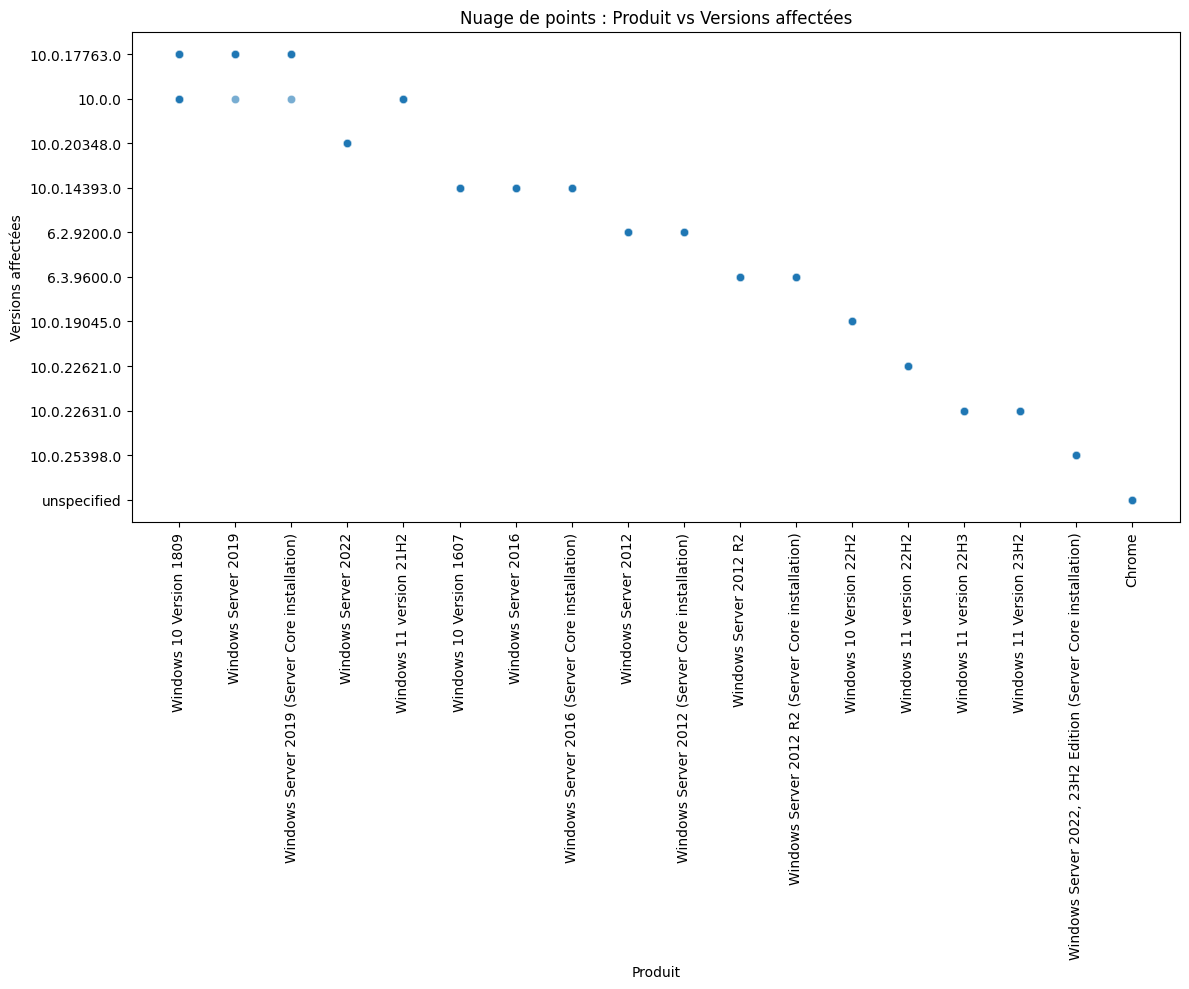

In [57]:
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_top_both, x="Produit", y="Versions affectées", alpha=0.6)

plt.xticks(rotation=90)
plt.title("Nuage de points : Produit vs Versions affectées")
plt.xlabel("Produit")
plt.ylabel("Versions affectées")
plt.tight_layout()
plt.show()

_Ce nuage de points met en évidence la répartition des versions affectées par produit._

_On observe que plusieurs produits, notamment Windows 10 Version 1809, Windows Server 2019, et Windows Server 2022, sont associés à des versions très touchées comme 10.0.17763.0, 10.0.20348.0, ou 10.0.14393.0._

## 16. Bar chart : top 10 versions les plus impactées par les vulnerabilités

Filtrer

In [58]:
versions = df_vis["Versions affectées"]
versions = versions[versions != "n/a"]

In [59]:
version_counts = versions.value_counts().head(10)

Plot

/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_92862/2037418214.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=version_counts.index, x=version_counts.values, palette="viridis")


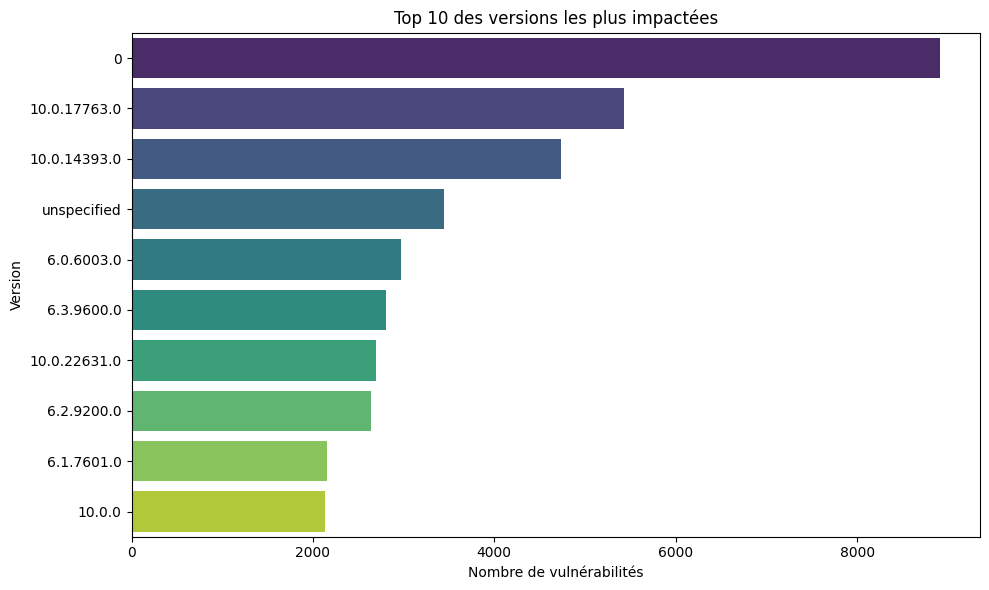

In [60]:
plt.figure(figsize=(10, 6))
sns.barplot(y=version_counts.index, x=version_counts.values, palette="viridis")

plt.title("Top 10 des versions les plus impactées")
plt.xlabel("Nombre de vulnérabilités")
plt.ylabel("Version")
plt.tight_layout()
plt.show()

_La version la plus impactée est étiquetée "0", ce qui indique vraisemblablement des données mal renseignées ou mal structurées, et constitue un biais important._

_La présence d’une catégorie "unspecified" en 4e position renforce l'idée qu’une part significative des données manque de précision sur les versions._

## 17. Evolution temporelle des vulnérabilités par type de bulletin (Avis/Alertes)

In [61]:
df_vis['Type'] = df_vis['Type'].str.strip() 
df_vis = df_vis[df_vis['Type'].isin(['Avis', 'Alerte'])]

In [62]:
df_vis['Date'] = pd.to_datetime(df_vis['Date'], errors='coerce')
df_vis['Mois'] = df_vis['Date'].dt.to_period('M').astype(str)

Groupe par mois et par type (avis/alerte)

In [63]:
df_evol = df_vis.groupby(['Mois', 'Type']).size().reset_index(name='Nombre')

Tri par mois chronologique

In [64]:
df_evol['Mois'] = pd.to_datetime(df_evol['Mois'])
df_evol = df_evol.sort_values('Mois')

Plot

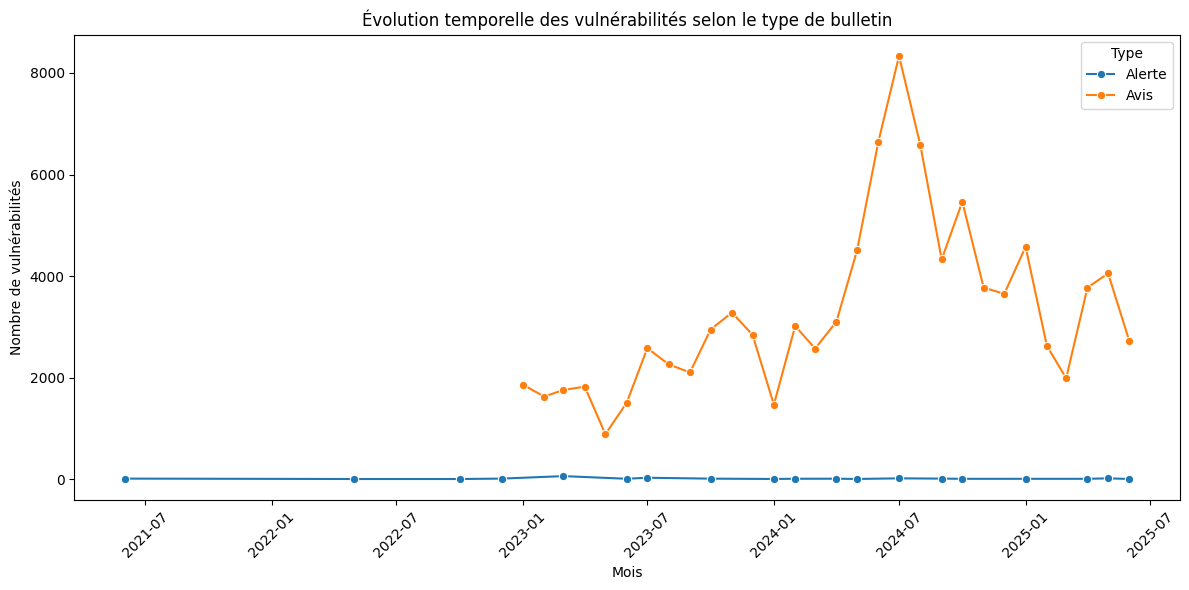

In [65]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_evol, x='Mois', y='Nombre', hue='Type', marker='o')
plt.title("Évolution temporelle des vulnérabilités selon le type de bulletin")
plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

_Les bulletins de type Avis connaissent une forte augmentation depuis début 2023, atteignant un pic autour de mi-2024 avec plus de 9 000 vulnérabilités publiées en un mois._

_Cette tendance marque une croissance continue et soutenue du volume de vulnérabilités traitées par les avis._

_En revanche, les alertes restent très rares et stables dans le temps, avec un nombre mensuel de vulnérabilités quasi nul, confirmant leur statut d’exception._

## 18. Vulnerabilités par editeur et type (alerte/avis)

Grouper par editeur et type

In [66]:
df_bar = df_vis.groupby(['Éditeur', 'Type']).size().unstack(fill_value=0)

Garder les 15 éditeurs les plus fréquents

In [67]:
df_bar = df_bar.sort_values(df_bar.columns.tolist(), ascending=False).head(15)

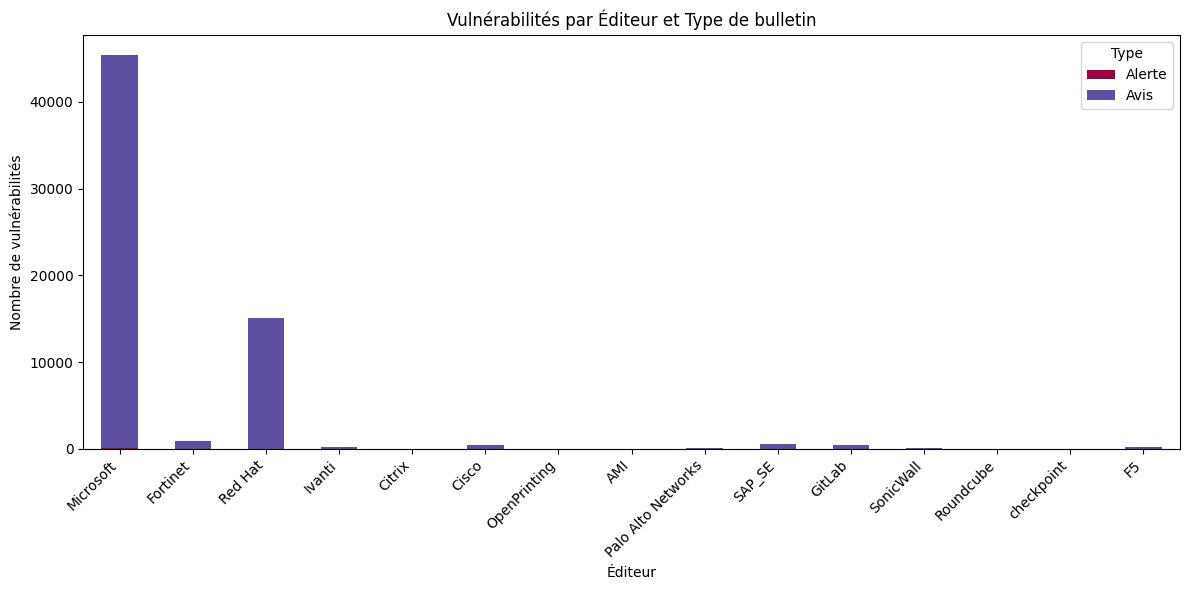

In [68]:

df_bar.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Spectral')
plt.title("Vulnérabilités par Éditeur et Type de bulletin")
plt.xlabel("Éditeur")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


_La très grande majorité des vulnérabilités sont publiées sous forme d’Avis._

_Microsoft et Red Hat concentrent à eux deux seuls une part massive du volume total, avec respectivement plus de 45 000 et 23 000 avis recensés, bien au-dessus des autres éditeurs._

_Le nombre de bulletins de type Alerte reste extrêmement faible pour tous les éditeurs, ce qui suggère que ce format est réservé à des cas exceptionnels._

## 19. Boxplot - Gravité (CVSS) par type de bulletin

Plot

/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_92862/1112535214.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_vis, x="Type", y="CVSS", palette="Set1")


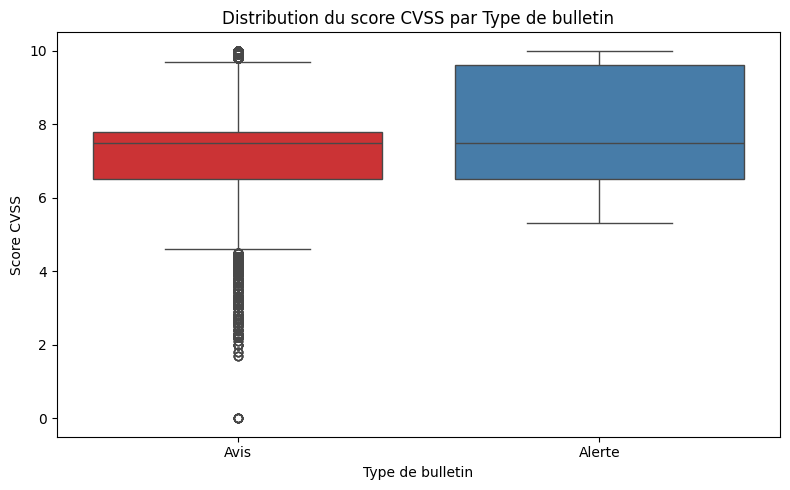

In [69]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_vis, x="Type", y="CVSS", palette="Set1")
plt.title("Distribution du score CVSS par Type de bulletin")
plt.xlabel("Type de bulletin")
plt.ylabel("Score CVSS")
plt.tight_layout()
plt.show()

_Les bulletins de type Alerte présentent une plus grande variabilité des scores CVSS, allant de 5 à 10, ce qui reflète une attention portée à des cas plus critiques ou urgents._

_En revanche, les Avis ont une distribution plus concentrée autour d’un score médian élevé (~7.5), avec beaucoup d’observations mais aussi de nombreux outliers à faible score._

_Cela suggère que les alertes sont réservées aux cas à fort impact potentiel, tandis que les avis couvrent un spectre plus large de vulnérabilités, y compris des cas moins graves._

## 20. Heatmap : nombre de vulnerabilités

Garder les 15 editeurs les plus fréquents

In [70]:
top_editeurs = df_vis['Éditeur'].value_counts().head(15).index
df_top = df_vis[df_vis['Éditeur'].isin(top_editeurs)]

Heatmap

In [71]:
heat_data = df_top.groupby(['Éditeur', 'Base Severity']).size().unstack(fill_value=0)
severity_order = ['Critique', 'Élevée', 'Moyenne', 'Faible', 'Non spécifié']
heat_data = heat_data[[s for s in severity_order if s in heat_data.columns]]

Plot

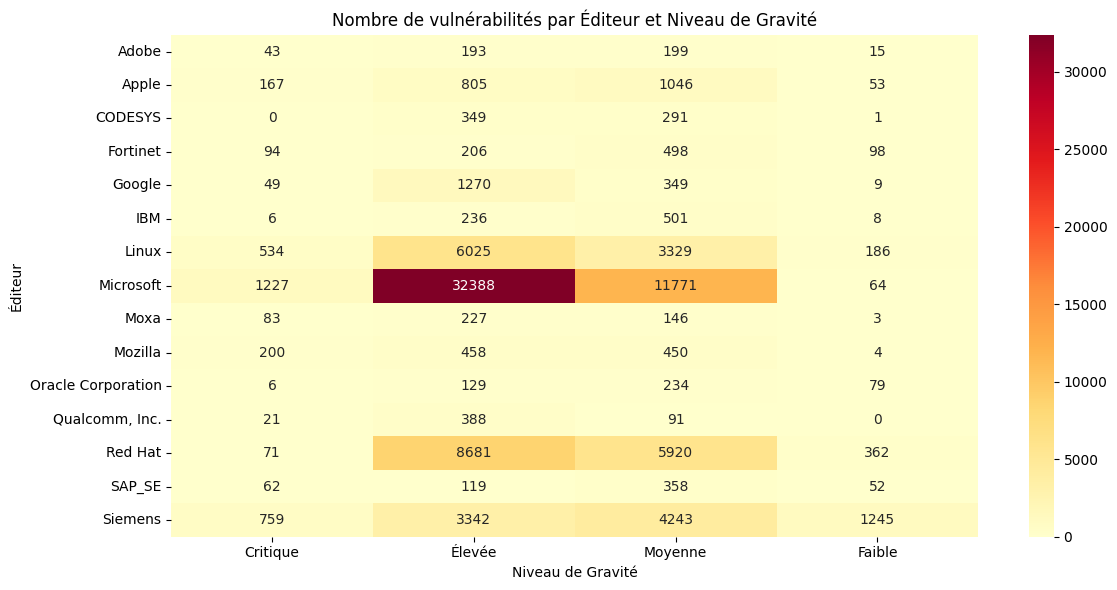

In [72]:
plt.figure(figsize=(12, 6))
sns.heatmap(heat_data, annot=True, fmt='d', cmap='YlOrRd')
plt.title("Nombre de vulnérabilités par Éditeur et Niveau de Gravité")
plt.xlabel("Niveau de Gravité")
plt.ylabel("Éditeur")
plt.tight_layout()
plt.show()

_La majorité des vulnérabilités se situent au niveau de gravité élevé, tout éditeurs confondus._

_Microsoft domine largement le classement avec plus de 32 000 vulnérabilités élevées, suivi par Red Hat (~12 000) et Linux (~6 000), ce qui reflète à la fois leur popularité et la surface d’attaque de leurs systèmes._

_Des éditeurs comme Siemens ou Oracle présentent un volume significatif de vulnérabilités critiques._

_Les vulnérabilités faibles restent minoritaires pour tous les éditeurs, ce qui montre que la majorité des failles identifiées sont considérées comme sérieuses._

## 21. Boxplot : Longueur de la description selon l'éditeur

In [73]:
top_editeurs = df_vis["Éditeur"].value_counts().head(20).index
df_top_editeurs = df_vis[df_vis["Éditeur"].isin(top_editeurs)]

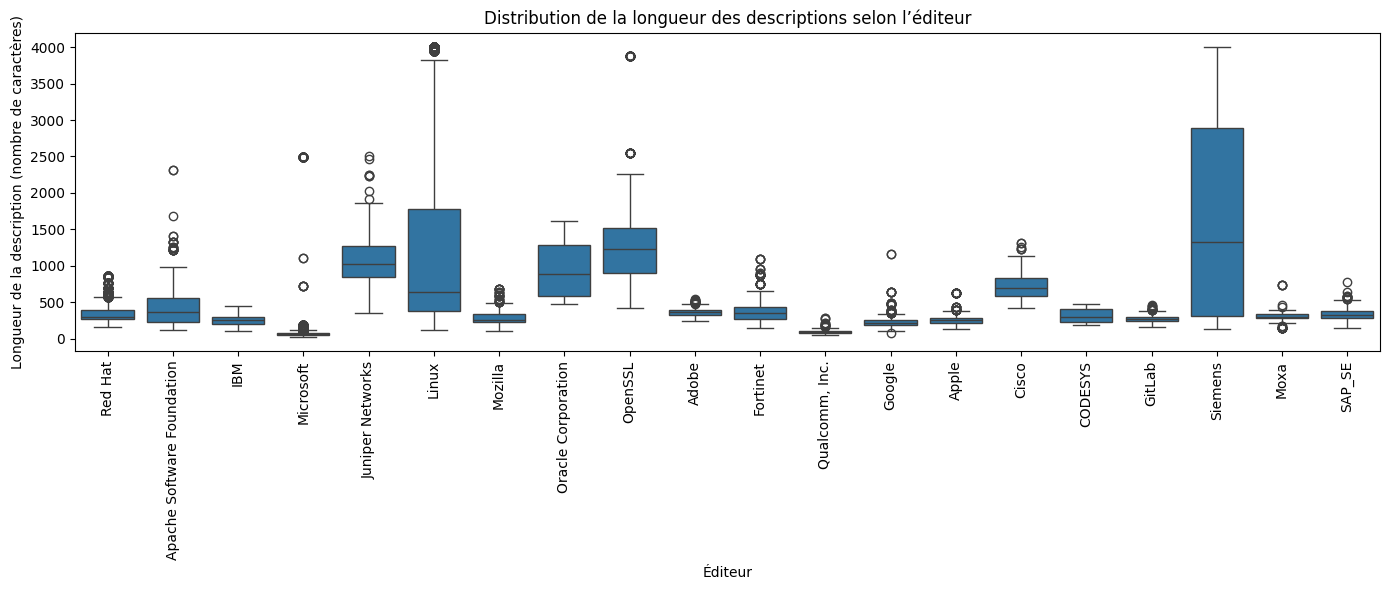

In [74]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_top_editeurs, x="Éditeur", y="Longueur description")
plt.xticks(rotation=90)
plt.title("Distribution de la longueur des descriptions selon l’éditeur")
plt.xlabel("Éditeur")
plt.ylabel("Longueur de la description (nombre de caractères)")
plt.tight_layout()
plt.show()


_La longueur des descriptions varie fortement selon les éditeurs._

_Siemens et Linux se distinguent avec des descriptions particulièrement longues, et une forte dispersion, témoignant probablement d’une documentation plus détaillée ou hétérogène._

_À l’inverse, Microsoft, Qualcomm ou Fortinet fournissent des descriptions très courtes et standardisées, avec peu de variation._

_D’autres éditeurs comme Red Hat, Oracle ou Cisco offrent une longueur de description intermédiaire mais relativement constante, ce qui peut refléter une politique éditoriale structurée._

## 22. Boxplot : Remote exploitable vs score EPSS

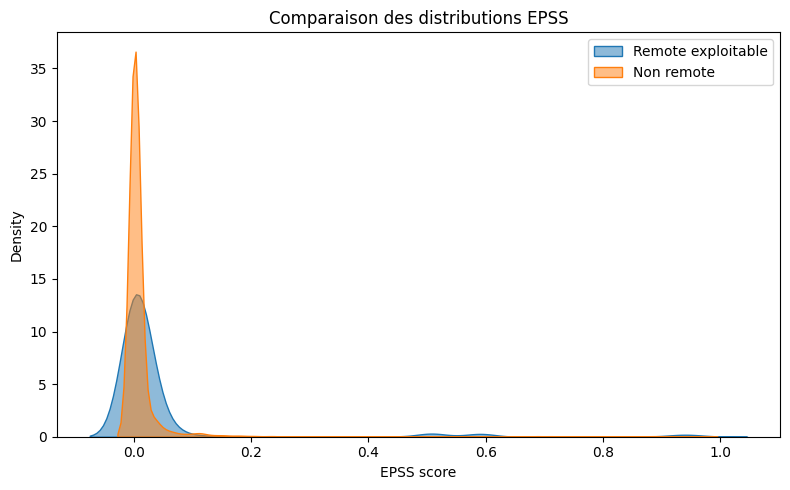

In [75]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df_vis[df_vis["Remote exploitable"] == True]["EPSS"], label="Remote exploitable", fill=True, alpha=0.5)
sns.kdeplot(df_vis[df_vis["Remote exploitable"] == False]["EPSS"], label="Non remote", fill=True, alpha=0.5)
plt.title("Comparaison des distributions EPSS")
plt.xlabel("EPSS score")
plt.legend()
plt.tight_layout()
plt.show()

_La majorité des vulnérabilités ont un score EPSS très faible, qu’elles soient exploitables à distance ou non._

_Cependant, les vulnérabilités exploitables à distance (courbe bleue) présentent une distribution légèrement plus étalée, avec une plus forte densité de scores > 0.1, voire jusqu’à 1, ce qui indique une probabilité d’exploitation significativement plus élevée._

_Ce graphique confirme que l’exploitabilité à distance augmente globalement le risque d’exploitation effectif selon le modèle EPSS._

## 23. Remote exploitable vs score CVSS

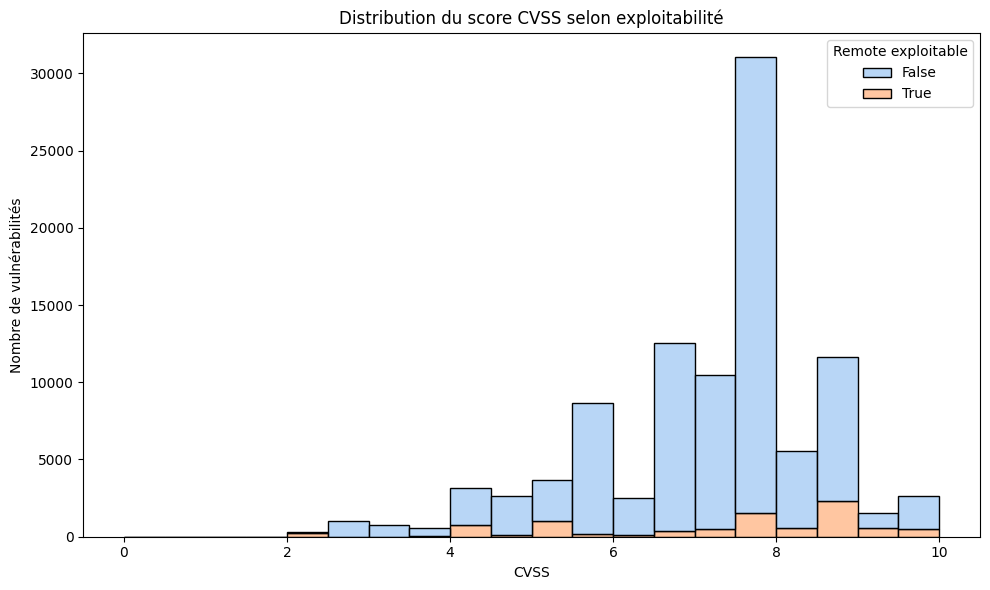

In [76]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_vis, x="CVSS", hue="Remote exploitable", multiple="stack", bins=20, palette="pastel")
plt.title("Distribution du score CVSS selon exploitabilité")
plt.xlabel("CVSS")
plt.ylabel("Nombre de vulnérabilités")
plt.tight_layout()
plt.show()


_La majorité des vulnérabilités se concentrent autour d’un score CVSS entre 7 et 8, ce qui correspond à une sévérité élevée._

_Les vulnérabilités exploitables à distance (en orange) sont présentes à tous les niveaux de score, mais deviennent particulièrement fréquentes à partir d’un score de 7, et surtout entre 8 et 9, ce qui traduit un risque accru en cas d’exploitation._

_Ce graphique montre que les vulnérabilités à fort impact sont souvent exploitables à distance, ce qui en fait des priorités critiques en matière de cybersécurité._

## 24. 3 CWE les plus fréquents pour chaque éditeur

In [77]:
top_editors = df_vis["Éditeur"].value_counts().head(6).index
df_filtered = df_vis[df_vis["Éditeur"].isin(top_editors)]

Obtenir les 3 CWE les plus fréquents pour chaque éditeur

In [78]:
top_cwes_per_editor = (
    df_filtered.groupby(["Éditeur", "CWE"])
    .size()
    .reset_index(name="count")
    .sort_values(["Éditeur", "count"], ascending=[True, False])
    .groupby("Éditeur")
    .head(3)
)

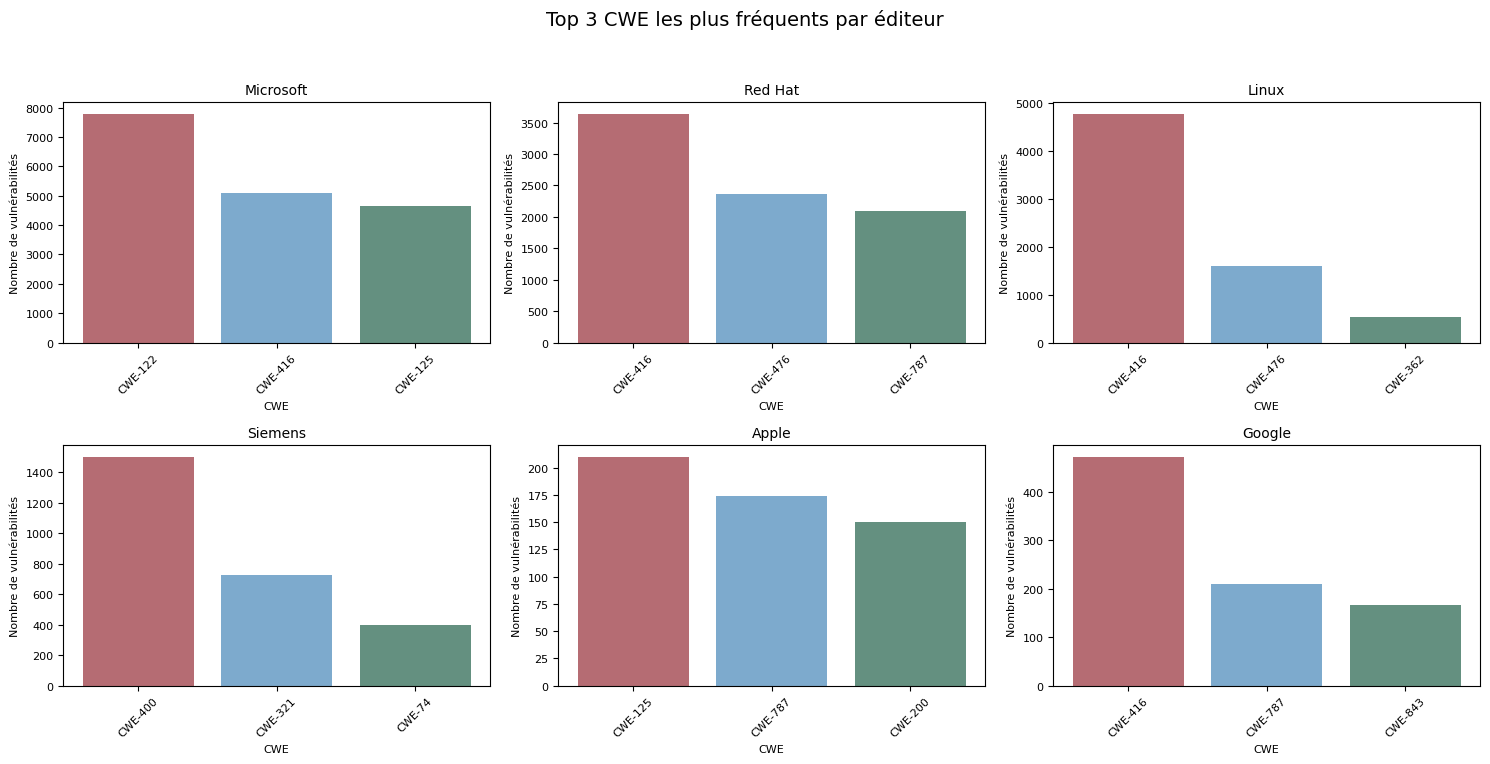

In [79]:
n_editors = len(top_editors)
n_cols = 3
n_rows = (n_editors + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
axes = axes.flatten()

colors = ["#B56C73", "#7DAACD", "#649080"]  # Couleurs pastel

for i, editor in enumerate(top_editors):
    ax = axes[i]
    data = top_cwes_per_editor[top_cwes_per_editor["Éditeur"] == editor]
    ax.bar(data["CWE"], data["count"], color=colors[:len(data)])
    ax.set_title(editor, fontsize=10)
    ax.set_xlabel("CWE", fontsize=8)
    ax.set_ylabel("Nombre de vulnérabilités", fontsize=8)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Supprimer les axes vides si le nombre d’éditeurs < n_rows * n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Top 3 CWE les plus fréquents par éditeur", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

_CWE-416 (use-after-free) est la vulnérabilité la plus récurrente, touchant Microsoft, Red Hat, Linux et Google._

_La majorité des CWE identifiées concernent la gestion de mémoire, avec notamment les failles CWE-416 (use-after-free), CWE-122 (débordement de tampon), CWE-125 (lecture hors limites), CWE-787 (écriture hors limites) et CWE-476 (référence de pointeur nul). Ces vulnérabilités restent un défi central en cybersécurité, affectant aussi bien les systèmes propriétaires que les environnements open source._

_Des vulnérabilités plus spécifiques apparaissent selon les contextes : CWE-400 (déni de service) dans les environnements industriels (Siemens), CWE-200 (exposition d’informations sensibles) chez Apple, ou CWE-843 (type confusion) dans les applications web et navigateurs (Google)._

# **Modèles non-supervisés**

## Prédire les CVSS - PCA - KMEANS

### Preprocessing

In [138]:
# data
df1 = df_IA.copy()

#preprocessing:
df1.drop_duplicates(inplace=True)
df1 = df1[(df1['CVSS'] != 'Non disponible') & (df1['CWE'] != 'Non disponible')]

df1.drop(inplace=True, columns=['Versions affectées','Produit','Lien', 'Base Severity', 'CVE', 'Description', 'ID_ANSSI', 'Titre'])

df1.dropna(inplace=True)
print("Nombre de ligne utilisée", max(df1.count(axis=0)))
df1 = df1[['CVSS', 'EPSS', 'CWE', 'Éditeur','Longueur description']]
df1['CVSS'] = pd.to_numeric(df1['CVSS'], errors='coerce')
df1 = pd.get_dummies(df1, columns=['Éditeur', 'CWE'])

df1 = df1.astype(float)

# affectation des variables
X = df1.drop('CVSS', axis = 1)
Y = df1['CVSS'] #Valeur cible

# Centrée-réduite
X_scaled = StandardScaler().fit_transform(X)

Nombre de ligne utilisée 98798


### ACP

In [139]:
pca = PCA(n_components=None)
pca_result = pca.fit_transform(X_scaled)

#### Nombres de Composantes principales

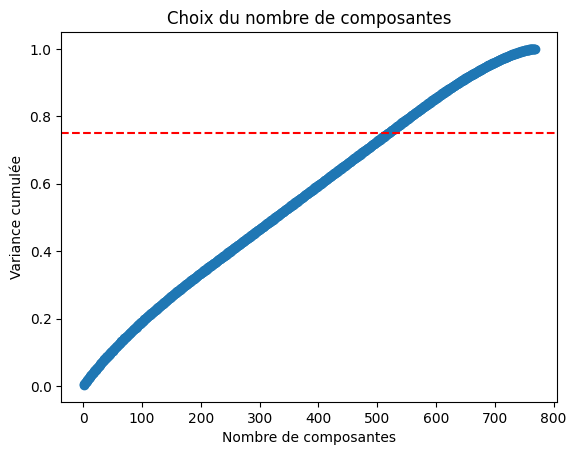

In [140]:
# Choix du nombre d'axes
explained_var = pca.explained_variance_ratio_
cum_var = explained_var.cumsum()

plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.75, color='r', linestyle='--')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulée')
plt.title('Choix du nombre de composantes')
plt.show()

On voit que le nombre d'axes qu'on devrait garder pour avoir une bonne représentativité est 550. Par souci de performances de l'ACP, on prendra 12.

In [141]:
# Correlation variables/axes
correlations = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_),
                            index=X.columns,
                            columns=[f'PC{i+1}' for i in range(len(X.columns))])

# Contributions :
contribs = correlations.abs()
contribs = contribs.div(contribs.sum(axis=0), axis=1)

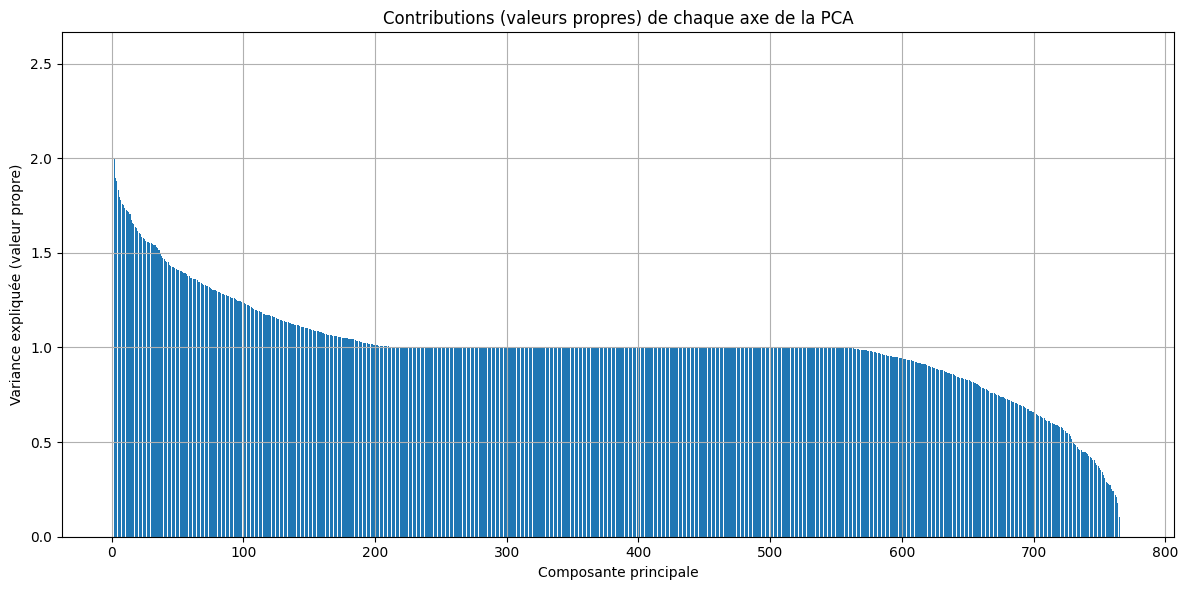

In [142]:

plt.figure(figsize=(12, 6))
plt.bar(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_)
plt.xlabel("Composante principale")
plt.ylabel("Variance expliquée (valeur propre)")
plt.title("Contributions (valeurs propres) de chaque axe de la PCA")
plt.grid(True)

plt.tight_layout()
plt.show()

/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_92862/3225599127.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_92862/3225599127.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_92862/3225599127.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_92862/3225599127.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

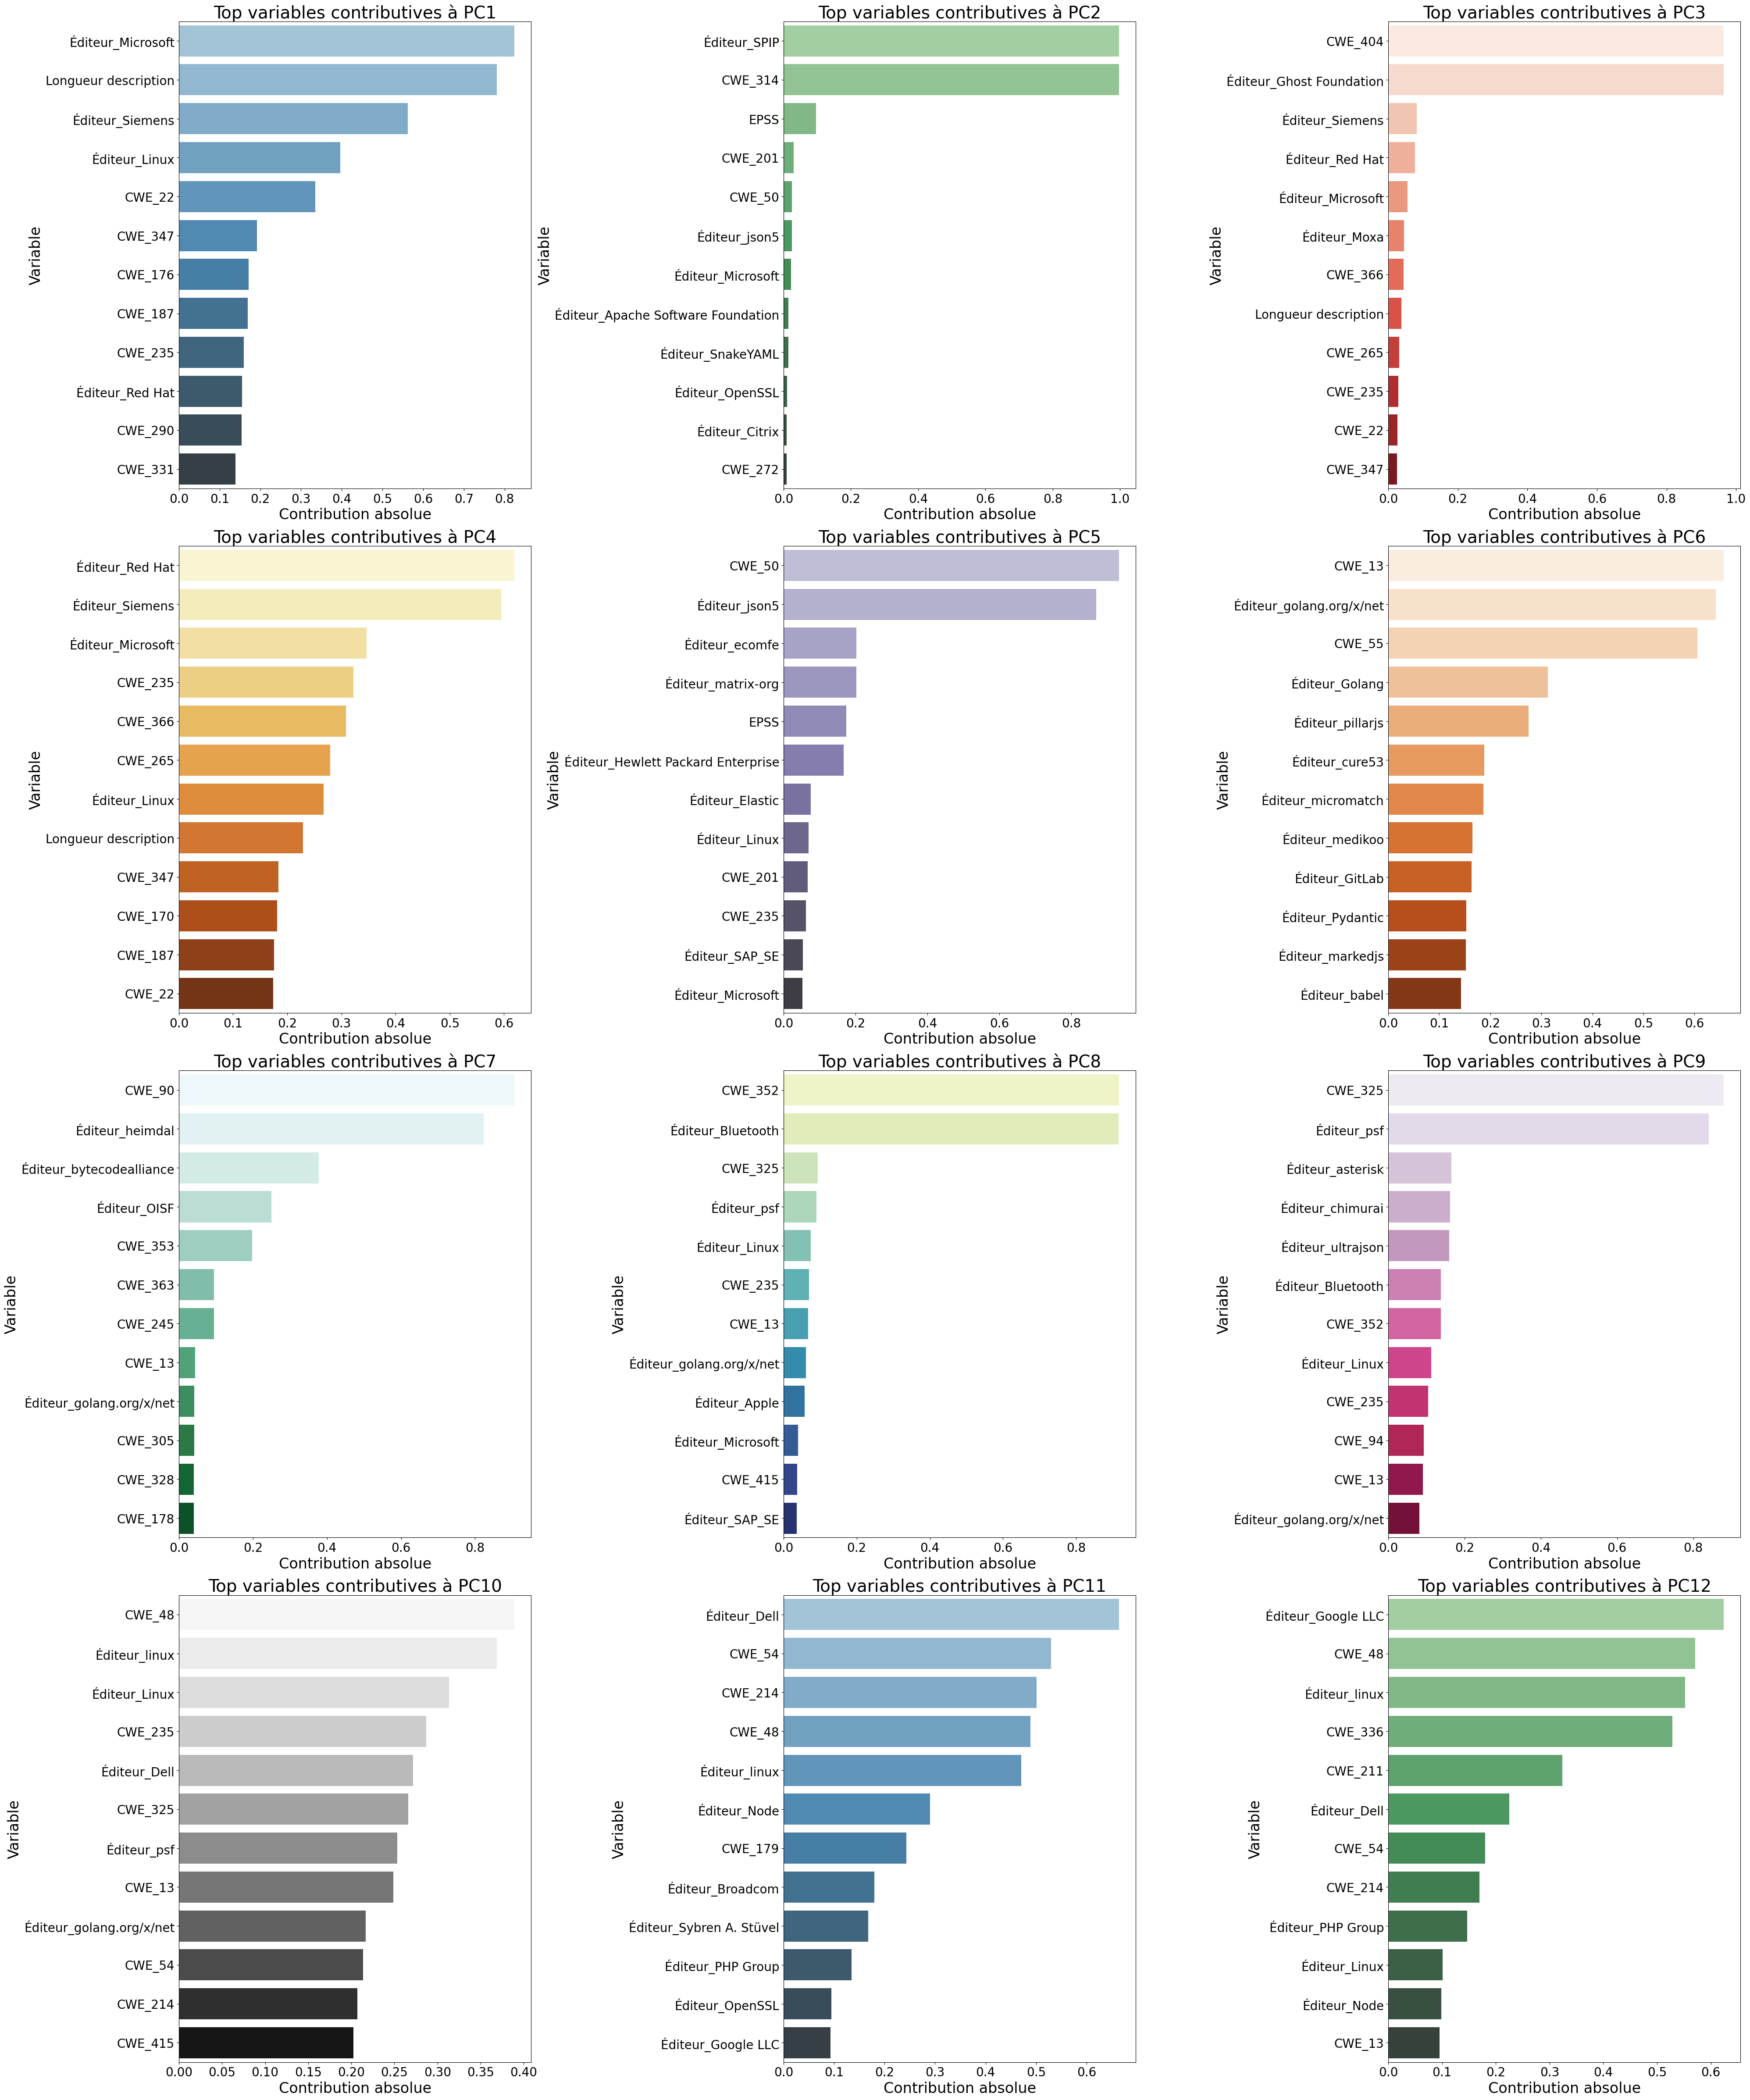

In [143]:
contribs_pc1_pc10 = correlations[[f'PC{i+1}' for i in range(12)]].abs()
top_n = 12

# Récupérer les top variables pour chaque axe
top_pcs = [contribs_pc1_pc10[f'PC{i+1}'].sort_values(ascending=False).head(top_n) for i in range(12)]

fig, axes = plt.subplots(4, 3, figsize=(40, 48))

palettes = ["Blues_d", "Greens_d", "Reds", "YlOrBr", "Purples_d", "Oranges", "BuGn", "YlGnBu", "PuRd", "Greys", "Blues_d", "Greens_d"]

for i in range(12):
    row, col = divmod(i, 3)
    sns.barplot(
        y=top_pcs[i].index,
        x=top_pcs[i].values,
        palette=palettes[i],
        ax=axes[row, col]
    )
    axes[row, col].set_title(f"Top variables contributives à PC{i+1}", fontsize=28)
    axes[row, col].set_xlabel("Contribution absolue", fontsize=24)
    axes[row, col].set_ylabel("Variable", fontsize=24)
    axes[row, col].tick_params(axis='both', labelsize=20)

plt.tight_layout()
plt.show()


#### Exemple d'un cercle de corrélation

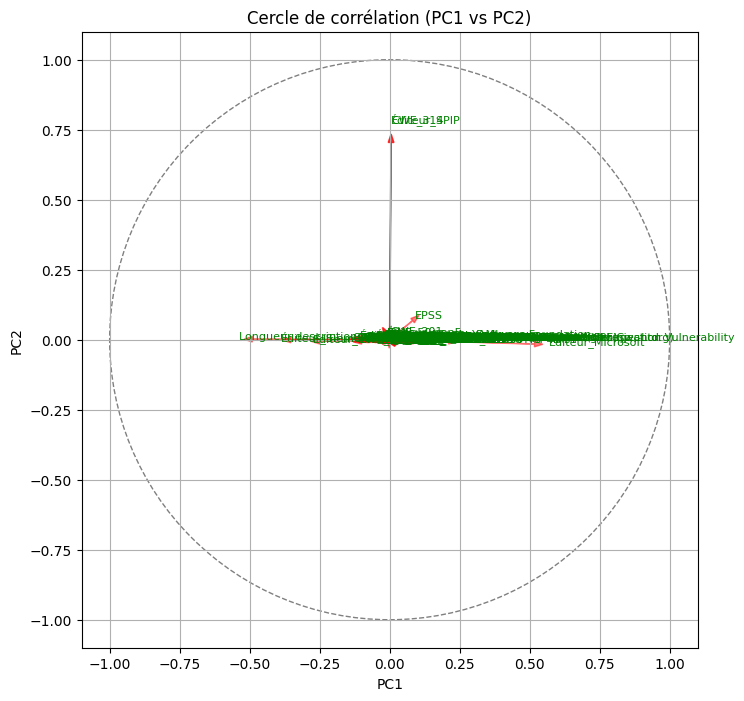

In [144]:
plt.figure(figsize=(8, 8))
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Afficher les flèches pour chaque variable
for i in range(len(X.columns)):
    plt.arrow(0, 0, 
              pca.components_[0, i], 
              pca.components_[1, i], 
              color='r', alpha=0.5, head_width=0.02)
    plt.text(pca.components_[0, i]*1.1, 
             pca.components_[1, i]*1.1, 
             X.columns[i], color='g', fontsize=8)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Cercle de corrélation (PC1 vs PC2)")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### KMeans

#### Choix du nombre de clusters

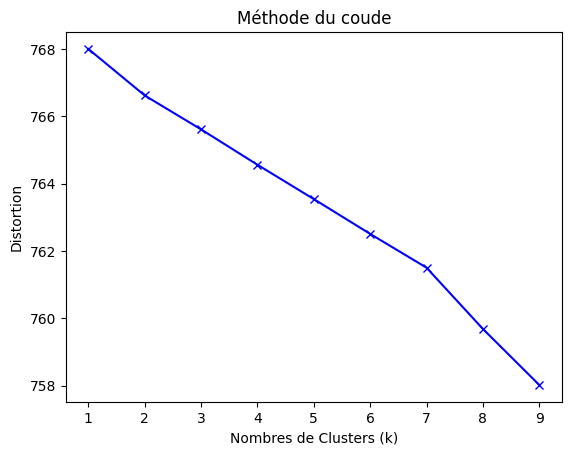

In [166]:
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
    
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    distortions.append(sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / X_scaled.shape[0])
    inertias.append(kmeanModel.inertia_)
    
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

#distortion
plt.plot(K, distortions, 'bx-')
plt.xlabel('Nombres de Clusters (k)')
plt.ylabel('Distortion')
plt.title('Méthode du coude')
plt.show()

On considérera que le nombre de clusters optimal est 3.

### KMeans x ACP

In [146]:
n = 12
pca = PCA(n_components=n)
pca_result = pca.fit_transform(X_scaled)

In [147]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto')
cluster_labels = kmeans.fit_predict(pca_result)

#### Visualisation

Par souci de visualisation, on choisira de représenter les variables uniquement sur les axes PC1 et PC2

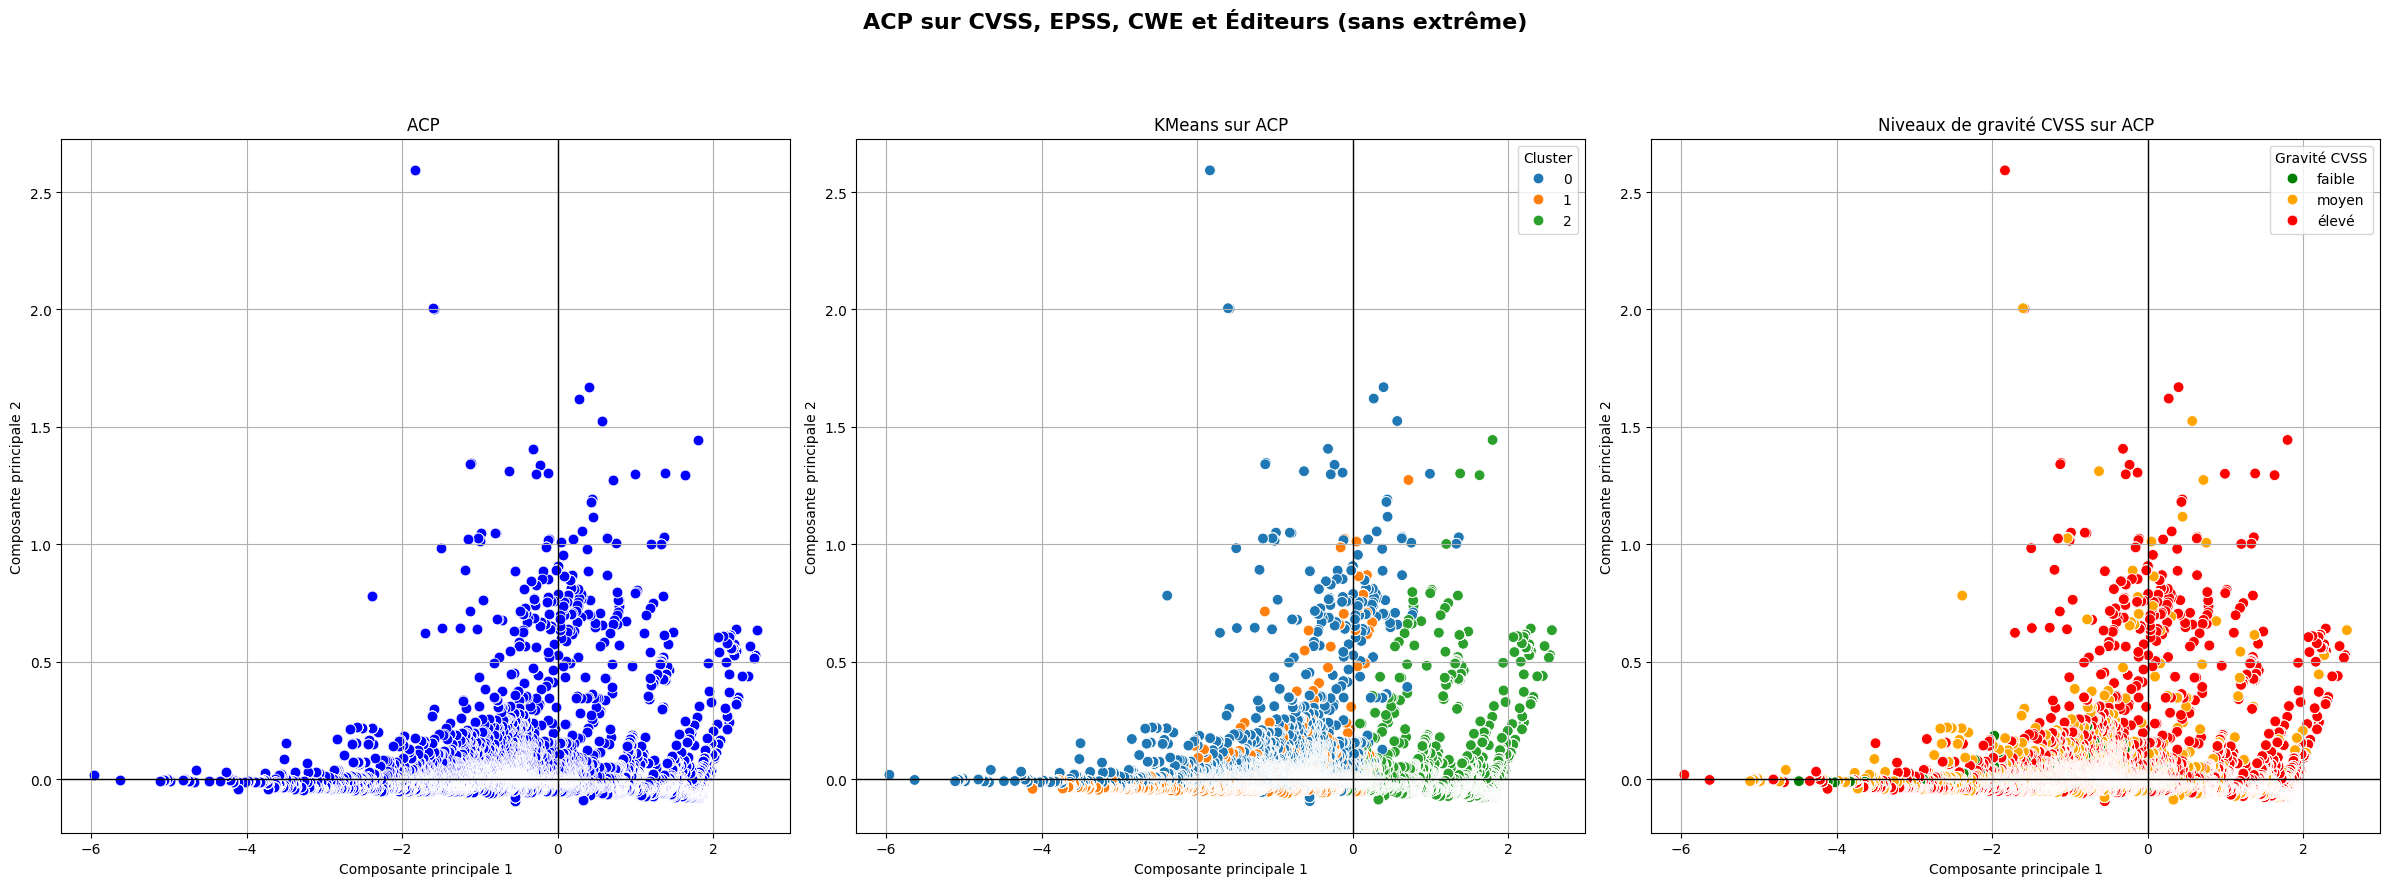

In [148]:
pca_df = pd.DataFrame(pca_result[:, :2], columns=["PC1", "PC2"])
pca_df_trimmed = pca_df.sort_values(by="PC1", ascending=False).iloc[3:]

pca_df_full = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(n)])
pca_df_full["PC1"] = pca_result[:, 0]
pca_df_full["PC2"] = pca_result[:, 1]
pca_df_full["cluster"] = cluster_labels
pca_df_full_trimmed = pca_df_full.sort_values(by="PC1", ascending=False).iloc[3:]

df1['PC1'] = pca_result[:, 0]
df1['PC2'] = pca_result[:, 1]
df1['cluster'] = cluster_labels
df1['cvss_niveau'] = pd.cut(
    df1['CVSS'],
    bins=[0, 4, 7, 10],
    labels=['faible', 'moyen', 'élevé'],
    include_lowest=True
)
pca_df_visu = df1.sort_values(by="PC1", ascending=False).iloc[3:]

# 4. Affichage des 3 plots côte à côte
fig, axes = plt.subplots(1, 3, figsize=(24, 9))
fig.suptitle("ACP sur CVSS, EPSS, CWE et Éditeurs (sans extrême)", fontsize=16, fontweight='bold')

# Subplot 1 : PCA simple
sns.scatterplot(ax=axes[0], x="PC1", y="PC2", data=pca_df_trimmed, s=60, color='blue')
axes[0].set_title("ACP ")
axes[0].axhline(0, color='black', linewidth=1)
axes[0].axvline(0, color='black', linewidth=1)
axes[0].set_xlabel("Composante principale 1")
axes[0].set_ylabel("Composante principale 2")
axes[0].grid(True)

# Subplot 2 : PCA + KMeans
sns.scatterplot(
    ax=axes[1], x="PC1", y="PC2",
    hue="cluster", data=pca_df_full_trimmed,
    palette="tab10", s=60
)
axes[1].set_title("KMeans sur ACP")
axes[1].axhline(0, color='black', linewidth=1)
axes[1].axvline(0, color='black', linewidth=1)
axes[1].set_xlabel("Composante principale 1")
axes[1].set_ylabel("Composante principale 2")
axes[1].grid(True)
axes[1].legend(title="Cluster")

# Subplot 3 : PCA + CVSS niveau
sns.scatterplot(
    ax=axes[2], x="PC1", y="PC2",
    hue="cvss_niveau", data=pca_df_visu,
    palette={'faible': 'green', 'moyen': 'orange', 'élevé': 'red'}, s=60
)
axes[2].set_title("Niveaux de gravité CVSS sur ACP")
axes[2].axhline(0, color='black', linewidth=1)
axes[2].axvline(0, color='black', linewidth=1)
axes[2].set_xlabel("Composante principale 1")
axes[2].set_ylabel("Composante principale 2")
axes[2].grid(True)
axes[2].legend(title="Gravité CVSS")

plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


In [149]:
df1['cluster'] = cluster_labels
df1.groupby('cluster')['CVSS'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,19682.0,6.357205,1.799716,0.0,4.9,6.5,7.5,10.0
1,31234.0,7.001255,1.342489,2.0,6.2,7.1,7.8,10.0
2,47882.0,7.463059,1.135515,2.1,6.8,7.8,8.1,10.0


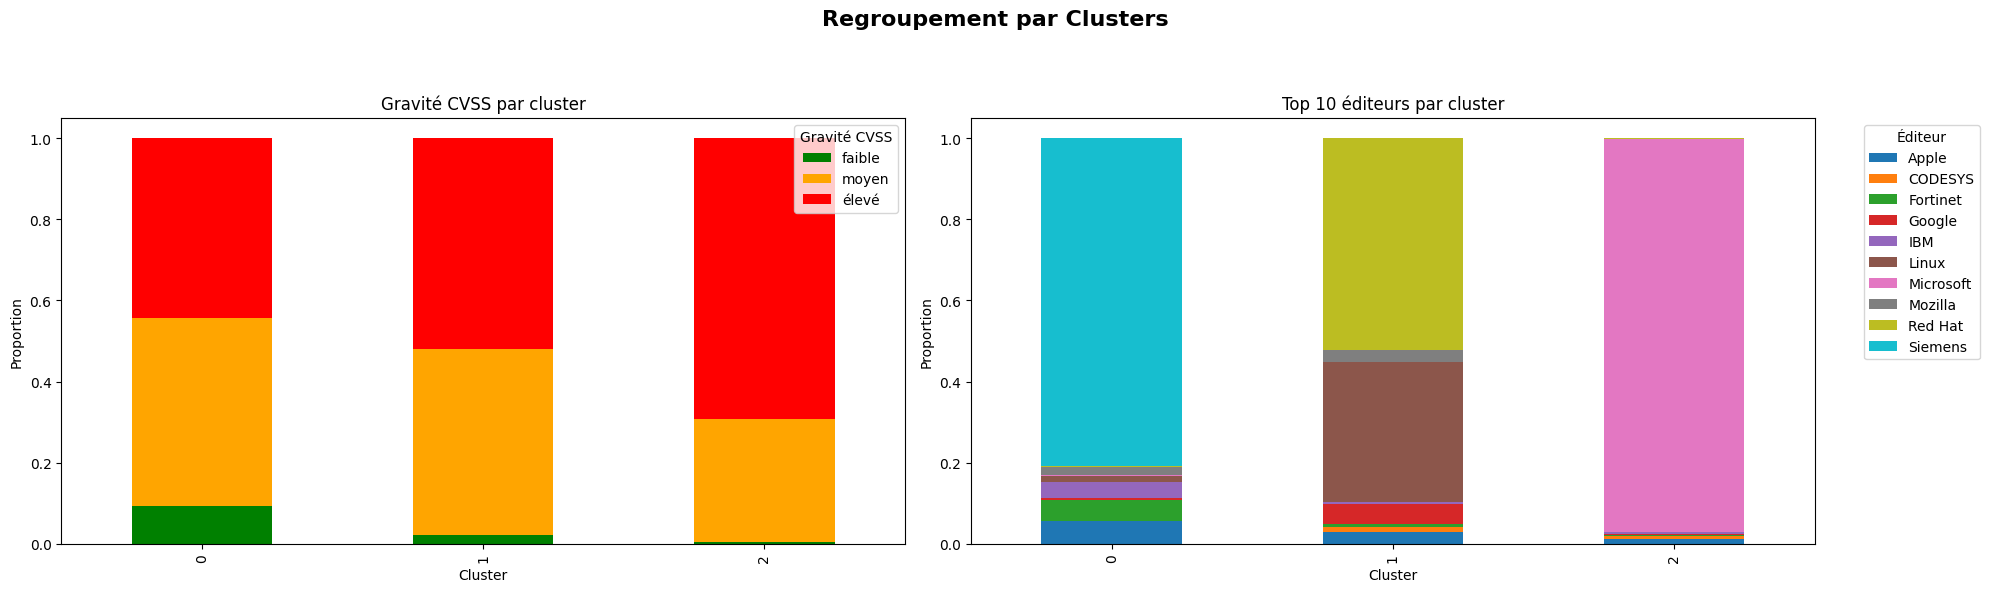

In [150]:
import pandas as pd
import matplotlib.pyplot as plt

editeur_cols = [col for col in df1.columns if col.startswith('Éditeur_')]
df1['Éditeur'] = df1[editeur_cols].idxmax(axis=1).str.replace('Éditeur_', '', regex=False)


df1['cvss_niveau'] = pd.cut(
    df1['CVSS'],
    bins=[0, 4, 7, 10],
    labels=['faible', 'moyen', 'élevé'],
    include_lowest=True
)


cross_tab_cvss = pd.crosstab(df1['cluster'], df1['cvss_niveau'])
proportions_cvss = cross_tab_cvss.div(cross_tab_cvss.sum(axis=1), axis=0)

top10_editeurs = df1['Éditeur'].value_counts().head(10).index
df_top_editeurs = df1[df1['Éditeur'].isin(top10_editeurs)]

cross_tab_editeurs = pd.crosstab(df_top_editeurs['cluster'], df_top_editeurs['Éditeur'])
proportions_editeurs = cross_tab_editeurs.div(cross_tab_editeurs.sum(axis=1), axis=0)


fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle("Regroupement par Clusters", fontsize=16, fontweight='bold')

# Plot 1 : CVSS
proportions_cvss.plot(
    kind='bar',
    stacked=True,
    ax=axes[0],
    color=['green', 'orange', 'red']
)
axes[0].set_title('Gravité CVSS par cluster')
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Proportion")
axes[0].legend(title="Gravité CVSS", loc='upper right')

# Plot 2 : Éditeurs
proportions_editeurs.plot(
    kind='bar',
    stacked=True,
    ax=axes[1],
    colormap='tab10'
)
axes[1].set_title('Top 10 éditeurs par cluster')
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Proportion")
axes[1].legend(title="Éditeur", bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


On voit bien que le clustering fonctionne efficacement sur les variables utilisées lors de l’entraînement. L’exemple ci-dessus illustre que le regroupement par éditeur est bien capté par l’algorithme. En revanche, les clusters ne correspondent pas aux niveaux de gravité CVSS, ce qui est cohérent puisque ces derniers n’étaient pas pris en compte dans la réduction de dimension (PCA) ni dans l’algorithme de clustering (KMeans).

## Prédire les Eiteurs - KMeans

In [158]:

np.random.seed(42)
n_samples = 500
df2 = df_IA.copy()
df2 = df2[['CVSS', 'Éditeur', 'EPSS','Remote exploitable','Longueur description']]
df2.dropna(inplace=True)

In [159]:
top_editors = df2['Éditeur'].value_counts().head(10).index
data_top = df2[df2['Éditeur'].isin(top_editors)].copy()
le_editor = LabelEncoder()
data_top['editor_encoded'] = le_editor.fit_transform(data_top['Éditeur'])


In [160]:
X = data_top[['CVSS', 'EPSS']]
Y = data_top['editor_encoded']

### KMeans

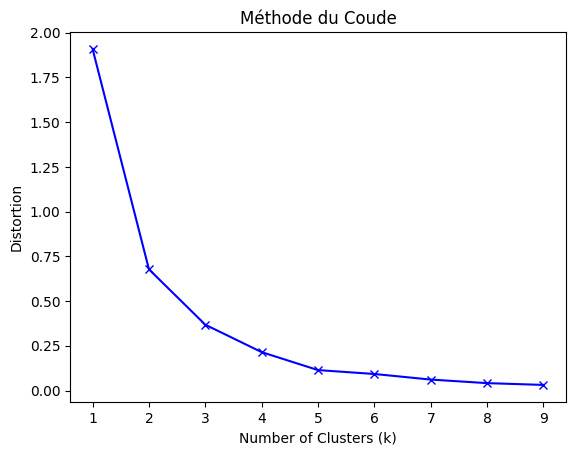

In [161]:
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
    
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / X.shape[0])    
    mapping1[k] = distortions[-1]

#distortion
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('Méthode du Coude')
plt.show()

Le nombre optimal de cluster est 2

In [162]:
kmeans = KMeans(n_clusters=2, random_state=42)
data_top['cluster'] = kmeans.fit_predict(X)

### Visualisation

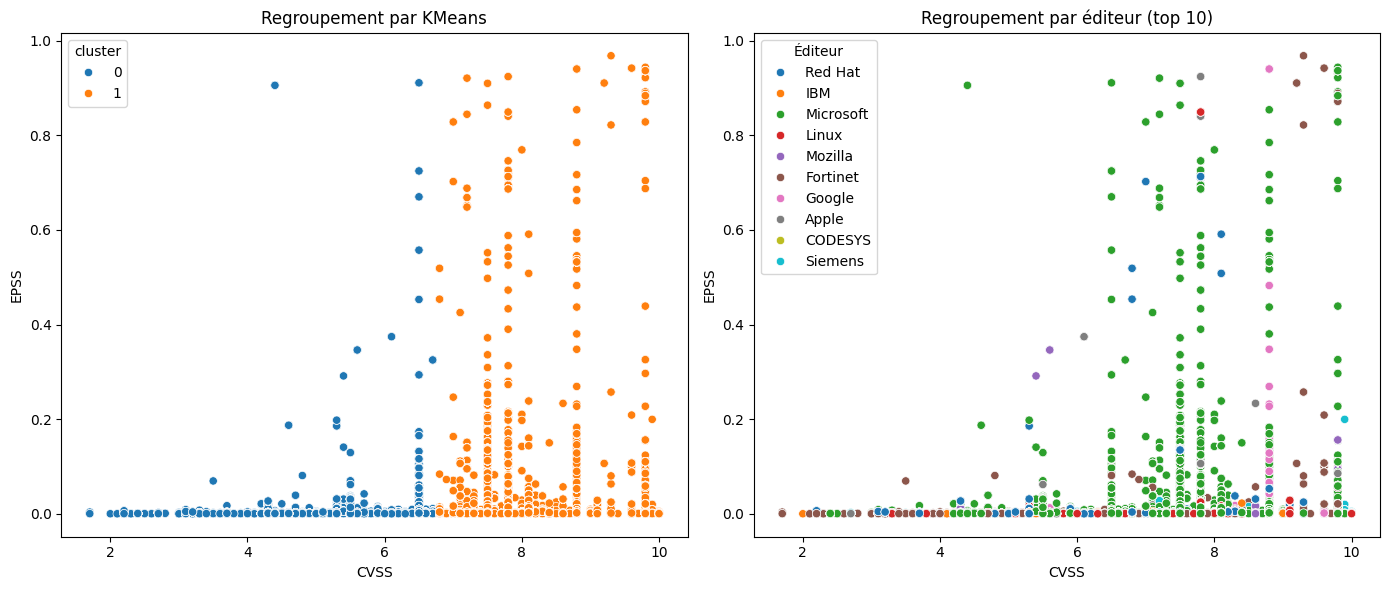

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(ax=axes[0], x='CVSS', y='EPSS', hue='cluster', data=data_top, palette='tab10')
axes[0].set_title('Regroupement par KMeans')
sns.scatterplot(ax=axes[1], x='CVSS', y='EPSS', hue='Éditeur', data=data_top, palette='tab10')
axes[1].set_title('Regroupement par éditeur (top 10)')
plt.tight_layout()
plt.show()


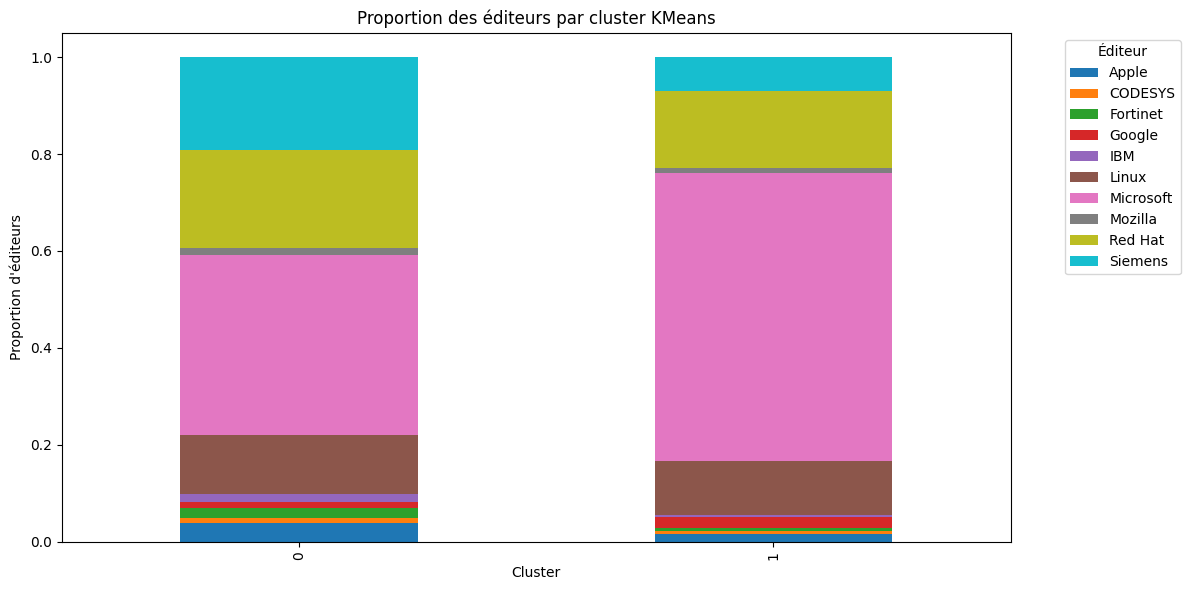

In [164]:
# BarPlot
cross_tab_inverse = pd.crosstab(data_top['cluster'], data_top['Éditeur'])
proportions_inverse = cross_tab_inverse.div(cross_tab_inverse.sum(axis=1), axis=0)

proportions_inverse.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab10')
plt.title('Proportion des éditeurs par cluster KMeans')
plt.xlabel("Cluster")
plt.ylabel("Proportion d'éditeurs")
plt.legend(title='Éditeur', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# **Modèles supervisés**

## Random Forest pour prédire Base Severity

Labellisation

In [100]:
features = ['Type', 'CWE', 'EPSS', 'Remote exploitable', 'Longueur description']
target = 'Base Severity'

le_type = LabelEncoder()
le_cwe = LabelEncoder()
le_target = LabelEncoder()

df_IA['Type'] = le_type.fit_transform(df_IA['Type'])
df_IA['CWE'] = le_cwe.fit_transform(df_IA['CWE'])
df_IA[target] = le_target.fit_transform(df_IA[target])

In [101]:
X = df_IA[features]
y = df_IA[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modèle Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Évaluation

In [102]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy : 0.963663967611336
Classification report:
              precision    recall  f1-score   support

    Critique       0.95      0.90      0.92      1248
      Faible       0.97      0.85      0.90       790
     Moyenne       0.95      0.96      0.95      9945
      Élevée       0.97      0.98      0.97     17657

    accuracy                           0.96     29640
   macro avg       0.96      0.92      0.94     29640
weighted avg       0.96      0.96      0.96     29640

Confusion matrix:
[[ 1119     1    50    78]
 [    1   668    87    34]
 [   21    12  9523   389]
 [   39    10   355 17253]]


Visualisation

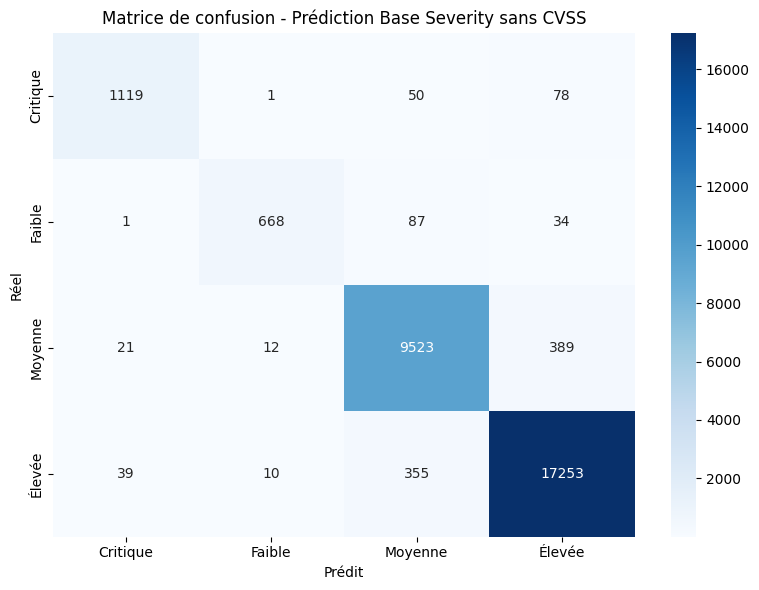

In [103]:
cm = confusion_matrix(y_test, y_pred)
labels = le_target.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion - Prédiction Base Severity sans CVSS')
plt.tight_layout()
plt.show()

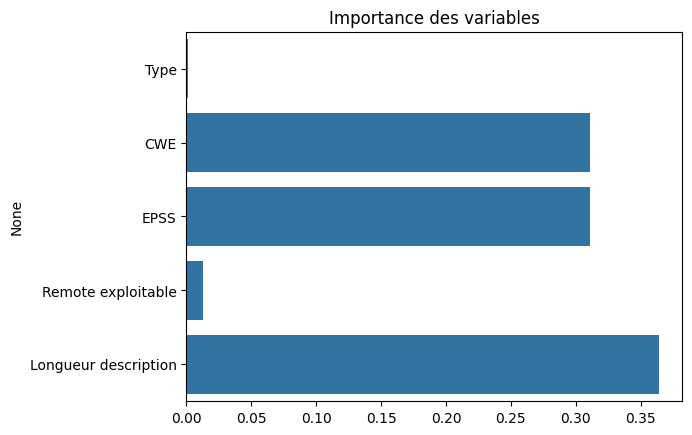

In [104]:
importances = model.feature_importances_
sns.barplot(x=importances, y=X.columns)
plt.title("Importance des variables")
plt.show()

Cross Validation

In [105]:
model_cv = RandomForestClassifier(random_state=42)

scores_acc = cross_val_score(model_cv, X, y, cv=5, scoring='accuracy')
print("Accuracy :", scores_acc.mean())

Accuracy : 0.8033665159094211


## Random Forest pour prédire EPSS

Data preparing

In [106]:
df_reg = df_IA.copy()
df_reg = df_reg[df_reg['EPSS'].notna()]
df_reg = df_reg[df_reg['EPSS'] != '']
df_reg['EPSS'] = df_reg['EPSS'].astype(float)

features = ['CWE','Type','Éditeur','Produit','Remote exploitable','Longueur description']

Labellisation

In [107]:
df_encoded = df_reg[features].copy()
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

Modèle Random Forest

In [108]:
X = df_encoded
y = df_reg['EPSS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [109]:
print("MAE :", mean_absolute_error(y_test, y_pred))
print("MSE :", mean_squared_error(y_test, y_pred))
#print("RMSE:", mean_squared_error(y_test, y_pred, squared=False)) #Meme chose que lignes suivantes mais ne marche pas avec toutes les versions

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

print("R²  :", r2_score(y_test, y_pred))

MAE : 0.01840064998147828
MSE : 0.005803254071415476
RMSE: 0.07617909208841672
R²  : 0.3605678797537396


Cross Validation

In [110]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores_mae = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
scores_rmse = (-cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error'))
scores_r2 = cross_val_score(model, X, y, cv=cv, scoring='r2')

print("MAE  : ", scores_mae.mean())
print("RMSE : ", scores_rmse.mean())
print("R²   : ", scores_r2.mean())

KeyboardInterrupt: 

Visualisation

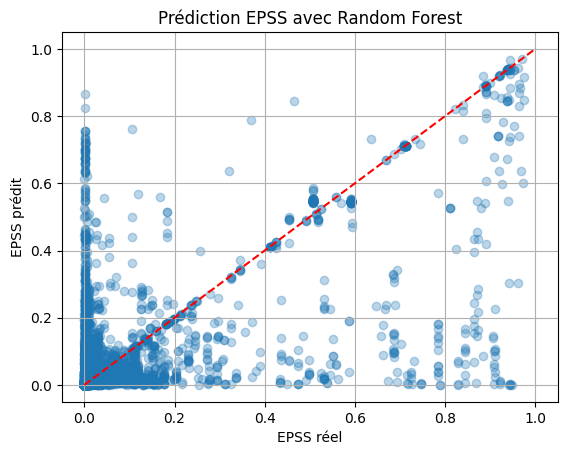

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("EPSS réel")
plt.ylabel("EPSS prédit")
plt.title("Prédiction EPSS avec Random Forest")
plt.plot([0, 1], [0, 1], 'r--')
plt.grid()
plt.show()

## XGBoost Regressor pour prédire EPSS

In [ ]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MAE :", mean_absolute_error(y_test, y_pred))
#print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
print("R²  :", r2_score(y_test, y_pred))

NameError: name 'XGBRegressor' is not defined

Cross Validation

In [ ]:
scores_mae = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
scores_rmse = -cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
scores_r2 = cross_val_score(model, X, y, cv=cv, scoring='r2')


print("MAE  : ", scores_mae.mean())
print("RMSE : ", scores_rmse.mean())
print("R²   : ", scores_r2.mean())

## Random Forest pour prédire l'éditeur

Random Forest sans SMOTE (échantillonage)

In [ ]:
df_clf = df_IA.dropna(subset=["CVSS", "EPSS", "CWE", "Remote exploitable", "Longueur description"])
df_clf = df_clf[df_clf["Éditeur"].map(df_clf["Éditeur"].value_counts()) > 50]  # éditeurs fréquents

le_editeur = LabelEncoder()
df_clf["Éditeur_encoded"] = le_editeur.fit_transform(df_clf["Éditeur"])

le_cwe = LabelEncoder()
df_clf["CWE_encoded"] = le_cwe.fit_transform(df_clf["CWE"].astype(str))

df_clf["Remote Exploitable"] = df_clf["Remote exploitable"].map({"True": 1, "False": 0})
df_clf["Remote Exploitable"].fillna(0, inplace=True)


features = [
    "CVSS",
    "EPSS",
    "CWE_encoded",
    "Remote Exploitable",
    "Longueur description"
]

X = df_clf[features]
y = df_clf["Éditeur_encoded"]


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le_editeur.classes_))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))


Cross Validation

In [ ]:
scores_acc = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Accuracy :", scores_acc.mean())

Visualisation

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_editeur.classes_,
            yticklabels=le_editeur.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Random Forest avec SMOTE

In [ ]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)


y_pred = model.predict(X_test)


print("Accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le_editeur.classes_))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

Cross Validation

In [ ]:
scores_acc = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Accuracy :", scores_acc.mean())

Visualisation

In [ ]:
importances = model.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title("Importance des variables")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=le_editeur.classes_,
            yticklabels=le_editeur.classes_, 
            annot=False, fmt="d", cmap="Blues")
plt.title("Matrice de confusion - Random Forest")
plt.xlabel("Prédiction")
plt.ylabel("Vérité")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
f1_scores = {}
for i, label in enumerate(le_editeur.classes_):
    try:
        f1_scores[label] = report_dict[str(i)]["f1-score"]
    except KeyError:
        f1_scores[label] = 0


f1_scores_sorted = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12, 6))
sns.barplot(x=list(f1_scores_sorted.keys()), y=list(f1_scores_sorted.values()))
plt.xticks(rotation=90)
plt.title("F1-score par éditeur")
plt.ylabel("F1-score")
plt.xlabel("Éditeur")
plt.tight_layout()
plt.show()

In [ ]:
support = {}
for i, label in enumerate(le_editeur.classes_):
    try:
        support[label] = report_dict[str(i)]["support"]
    except KeyError:
        support[label] = 0  


plt.figure(figsize=(12, 6))
sns.barplot(x=list(support.keys()), y=list(support.values()))
plt.xticks(rotation=90)
plt.title("Nombre d’exemples par éditeur dans le test set")
plt.ylabel("Exemples")
plt.xlabel("Éditeur")
plt.tight_layout()
plt.show()